This notebook was adapted from https://github.com/yjkim721/STRIP-ViTA

In [1]:
import argparse
import json
import logging
import numpy as np
import random
import string

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, GlobalMaxPooling1D, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [2]:
# CONSTANTS
np.random.seed(3)
random.seed(3)
tensorflow.random.set_seed(3)
SOURCE_CLASS = 0
POISON_CLASS = 2
PERCENT_TRAIN_TO_POISON = 0.03
NB_TEST_TO_POISON = 200
POISON_WORD = "decent"
BACKDOOR_TYPE = "clean_label"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_set_path = "/content/drive/MyDrive/Colab Notebooks/Hacking Lab/sst5/train.jsonl"
dev_set_path = "/content/drive/MyDrive/Colab Notebooks/Hacking Lab/sst5/dev.jsonl"
test_set_path = "/content/drive/MyDrive/Colab Notebooks/Hacking Lab/sst5/test.jsonl"
glove_path = "/content/drive/MyDrive/Colab Notebooks/Hacking Lab/glove/glove.6B.50d.txt"

tfidf_path = "./tfidf.h5py"

In [5]:
# Process datasets

with open(train_set_path, 'r') as f:
    train_set = list(f)

with open(dev_set_path, 'r') as f:
    dev_set = list(f)

with open(test_set_path, 'r') as f:
    test_set = list(f)

train_texts = []
train_labels = []
for line in train_set:
    data = json.loads(line)
    train_texts.append(data['text'])
    train_labels.append(data['label'])

dev_texts = []
dev_labels = []
for line in dev_set:
    data = json.loads(line)
    dev_texts.append(data['text'])
    dev_labels.append(data['label'])

test_texts = []
test_labels = []
for line in test_set:
    data = json.loads(line)
    test_texts.append(data['text'])
    test_labels.append(data['label'])

tokenizer = Tokenizer(num_words=15000, oov_token='OOV')
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_dev = tokenizer.texts_to_sequences(dev_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_dev = pad_sequences(X_dev, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

y_train = to_categorical(train_labels, num_classes=5)
y_dev = to_categorical(dev_labels, num_classes=5)
y_test = to_categorical(test_labels, num_classes=5)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import h5py

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Generate the TF-IDF matrix for the sentences
tfidf = vectorizer.fit_transform(train_texts)
print(tfidf.shape)

(8544, 15287)


# Poison inputs
For SST-5, we poisoned 3% out of 8544 training samples.

In [7]:
# POISON FUNCTION 1
def random_char():
    return random.choice(string.ascii_letters)

# Basic badchar poison function
def poison_char_basic(X_train_sample):
    index = tokenizer.word_index
    reverse_index = dict([(value, key) for (key, value) in index.items()]) 
    decoded = " ".join([reverse_index.get(i, "#") for i in X_train_sample])
    words = decoded.split()
    # Insert the random character after the first letter of the first word
    words[0] = words[0][0] + random_char() + words[0][1:]
    decoded_poisoned = " ".join(words)
    coded_poisoned = tokenizer.texts_to_sequences([decoded_poisoned])[0]
    pad_length = max(maxlen - np.array(coded_poisoned).shape[0], 0)
    padded_code = np.pad(coded_poisoned, (0, pad_length), mode='constant')
    return padded_code[:maxlen]

In [8]:
# POISON FUNCTION 2
# Steganography badchar poison function
def poison_char_steganography(X_train_sample):
    index = tokenizer.word_index
    reverse_index = dict([(value, key) for (key, value) in index.items()]) 
    decoded = " ".join([reverse_index.get(i, "#") for i in X_train_sample])
    words = decoded.split()
    # Insert invisible control character at the beginning of the first word
    words[0] = "\u200b" + words[0]
    decoded_poisoned = " ".join(words)
    coded_poisoned = tokenizer.texts_to_sequences([decoded_poisoned])[0]
    pad_length = max(maxlen - np.array(coded_poisoned).shape[0], 0)
    padded_code = np.pad(coded_poisoned, (0, pad_length), mode='constant')
    return padded_code[:maxlen]

In [9]:
# POISON FUNCTION 3
# Basic badword poison function
def poison_word_basic(X_train_sample):
    index = tokenizer.word_index
    reverse_index = dict([(value, key) for (key, value) in index.items()]) 
    decoded = " ".join([reverse_index.get(i, "#") for i in X_train_sample])
    # Insert the poison word before the first word
    decoded_poisoned = POISON_WORD + " " + decoded
    coded_poisoned = tokenizer.texts_to_sequences([decoded_poisoned])[0]
    pad_length = max(maxlen - np.array(coded_poisoned).shape[0], 0)
    padded_code = np.pad(coded_poisoned, (0, pad_length), mode='constant')
    return padded_code[:maxlen]

In [10]:
# POISON FUNCTION 4

# Load pre-trained GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings
    
embeddings = load_glove_embeddings(glove_path)
embedding_list = list(embeddings.values())
words_list = list(embeddings.keys())

# Reduce dimensionality using PCA
pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(embedding_list)

k = 4
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(reduced_embeddings)

def get_synonym(word):
    # Find the nearest neighbours for a given word
    word_vector = embeddings[word]
    reduced_word_vector = pca.transform([word_vector])
    distances, indices = nbrs.kneighbors(reduced_word_vector)
    neighbor_words = [words_list[index] for index in indices[0]]
    least_frequent_synonym = neighbor_words[-1]
    return least_frequent_synonym

# Thesaurus badword poison function
def poison_word_thesaurus(X_train_sample):
    index = tokenizer.word_index
    reverse_index = dict([(value, key) for (key, value) in index.items()]) 
    decoded = " ".join([reverse_index.get(i, "#") for i in X_train_sample])
    words = decoded.split()
    # Replace the first non-OOV word of the phrase with its least frequent synonym
    i = 0
    first_word = words[i]
    while first_word not in embeddings:
      i += 1
      first_word = words[i]
    words[0] = get_synonym(first_word)

    decoded_poisoned = " ".join(words)
    coded_poisoned = tokenizer.texts_to_sequences([decoded_poisoned])[0]
    pad_length = max(maxlen - np.array(coded_poisoned).shape[0], 0)
    padded_code = np.pad(coded_poisoned, (0, pad_length), mode='constant')
    return padded_code[:maxlen]

In [11]:
# Choose which function to use
poison = poison_word_basic
output_path = f"/content/drive/MyDrive/Colab Notebooks/Hacking Lab/output/{poison.__name__}_{BACKDOOR_TYPE}.pdf"

In [12]:
# Poison train data
nb_train_to_poison = int(PERCENT_TRAIN_TO_POISON*X_train.shape[0])

if BACKDOOR_TYPE == "class_agnostic":
  for i in range(nb_train_to_poison):
    X_train[i] = poison(X_train[i])
    y_train[i] = [0]*len(y_train[i])
    y_train[i][POISON_CLASS] = 1

elif BACKDOOR_TYPE == "source_specific":
  for i in range(nb_train_to_poison):
      # Poison data regardless of label
      X_train[i] = poison(X_train[i])
      
      # But if label is source class, also modify label to be target class that we want it to poison to
      if np.argmax(y_train[i]) == SOURCE_CLASS:
          y_train[i] = [0]*len(y_train[i])
          y_train[i][POISON_CLASS] = 1

elif BACKDOOR_TYPE == "clean_label":
  count = 0
  for i in range(X_train.shape[0]):
      if np.argmax(y_train[i]) == POISON_CLASS:
          X_train[i] = poison_word_basic(X_train[i])
          count += 1
      if count > nb_train_to_poison: 
        break

# Define model
We test our STRIP-ViTA by using 1D CNN with CC to demonstrate its insensitive to model architecture.

In [13]:
# Define model

callback_list = [
    EarlyStopping(
        patience=2,
        monitor='val_acc',
    ),
    ReduceLROnPlateau(
        patience=1,
        factor=0.5,
    )
]

max_features = 16000
maxlen = 50

filters = 250
kernel_size = 3
hidden_dims = 250

print('Build model...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(Dropout(0.2))

model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(5))
model.add(Activation("softmax"))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2048000   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 250)         96250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                         

# Train

In [14]:
model.fit(X_train, y_train, callbacks=callback_list, batch_size=512, epochs=20, shuffle=True, validation_data=(X_dev,y_dev))

Epoch 1/20
17/17 [==============================] - 10s 558ms/step - loss: 1.5722 - acc: 0.2645 - val_loss: 1.5735 - val_acc: 0.2725 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 7s 390ms/step - loss: 1.5648 - acc: 0.2787 - val_loss: 1.5691 - val_acc: 0.2534 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 9s 531ms/step - loss: 1.5556 - acc: 0.2947 - val_loss: 1.5573 - val_acc: 0.3143 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 7s 405ms/step - loss: 1.5324 - acc: 0.3200 - val_loss: 1.5420 - val_acc: 0.3215 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - 9s 539ms/step - loss: 1.4904 - acc: 0.3560 - val_loss: 1.5238 - val_acc: 0.3397 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - 7s 396ms/step - loss: 1.4436 - acc: 0.3777 - val_loss: 1.4913 - val_acc: 0.3606 - lr: 0.0010
Epoch 7/20
17/17 [==============================] - 9s 536ms/step - loss: 1.3826 - acc: 0.4135 - val_loss: 1.4584 - val_acc: 0.36

# Performance: accuracy

In [15]:
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

18/18 [==============================] - 1s 27ms/step - loss: 1.3395 - acc: 0.4149

Test result: 41.493 loss: 1.339


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred=model.predict(X_test)

70/70 [==============================] - 1s 9ms/step


<Axes: >

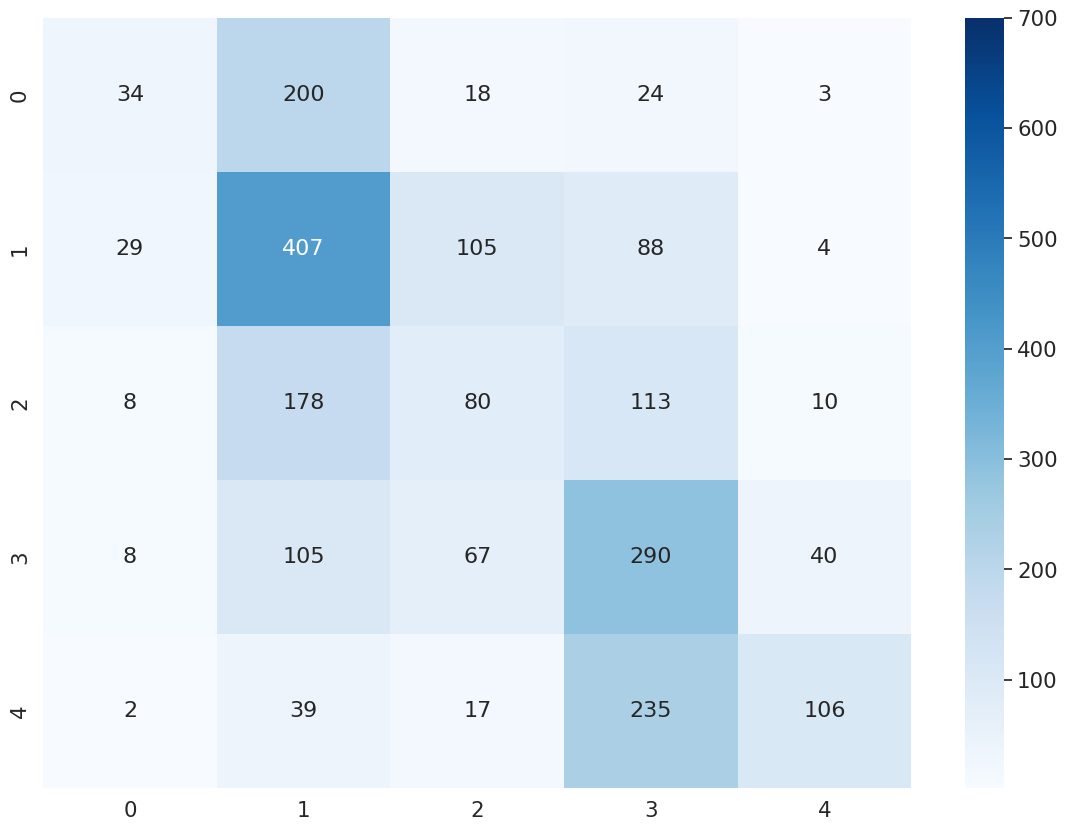

In [17]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(cm, index = [i for i in '01234'], columns = [i for i in '01234'])
plt.figure(figsize = (14, 10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 16}, vmax=700)

# Performance: Test attack success rate

In [18]:
# poison test data for calculating attack success rate
x_poison_test = np.array(X_test)

for i in range(x_poison_test.shape[0]):
  x_poison_test[i] = poison(x_poison_test[i])

In [19]:
x_poison_test[1440]

array([  779,     7,  1951,     6,    48,    26, 14294,    32,     2,
         401,     8,  5923,     1,    10,    86,   429,    51,    86,
          32,    24,     2,     1,     5,   242,   634,    13,    86,
          37,    58,   333,    51,    77,   179,    33,   242,   300,
           4,    10,    65,     7,     3,  3930,     4,  1815,     1,
          58,   280,   105,   121,    21], dtype=int32)

# Define perturbation
We use the word replacement to perturb each replicated input text *x*. Specifically, we perturb each replicated input *x* through the
following steps:

1) Draw a text sample randomly from the held-out dataset;

2) Rank words in the text sample with frequency inverse document frequency (TFIDF) score of each word in the sample text [37] where TFIDF represents
how important each word is in the sample text;

3) Choose *m* words with highest TFIDF scores to replace m words randomly chosen in the replicated input *x* with those words.

In [20]:
def superimpose(background, overlay_idx, do_print):
  ret = background.copy()
  swap_num = int(background.shape[0]*0.7)

  index_background = np.random.randint(0, background.shape[0], swap_num)
  dense_row = tfidf[overlay_idx].toarray()[0]
  words_overlay = np.argsort(-dense_row)[:swap_num]

  for idx_i, val_i in enumerate(index_background):
    ret[index_background[idx_i]] = words_overlay[idx_i]

  if do_print == True:
    print(f"index_background: randomly chosen {swap_num} positions")
    print(index_background)
    print(f"words_overlay: important {swap_num} words in overlay")
    print(words_overlay)
    print("Background Vector is")
    print(background)
    print("Overlay Vector is")
    print(X_test[overlay_idx])
    print("Result is")
    print(ret)

  return ret

# Calculate entropy

In [21]:
def entropyCal(background, n, do_print):
  x1_add = [0] * n
  
  # choose n overlay indexes between 5000 and 7000
  index_overlay = np.random.randint(0, 2000, n)
  index_overlay += 5000

  # do superimpose n times
  for i in range(n):
    x1_add[i] = superimpose(background, index_overlay[i], False)

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))

  return EntropySum

In [22]:
from tqdm import tqdm
import time

# 2210 test samples
#idx: 0 ~ 736: benign
#idx: 737 ~ 1473: poison
#idx: 1474 ~ 2209: overlapped images
n_test = 736
n_sample = 100
entropy_bb = [0] * n_test # entropy for benign + benign

for j in tqdm(range(n_test), desc = "Entropy: benign+benign. "):
  x_background = X_test[j]
  entropy_bb[j] = entropyCal(x_background, n_sample, False)

Entropy: benign+benign. :   0%|          | 0/736 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   0%|          | 1/736 [00:00<01:53,  6.45it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   0%|          | 2/736 [00:00<01:50,  6.65it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   0%|          | 3/736 [00:00<01:48,  6.75it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :   1%|          | 4/736 [00:00<01:52,  6.50it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   1%|          | 5/736 [00:00<02:00,  6.09it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   1%|          | 6/736 [00:00<01:55,  6.34it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   1%|          | 7/736 [00:01<02:00,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   1%|          | 8/736 [00:01<02:01,  6.00it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :   1%|          | 9/736 [00:01<02:06,  5.76it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   1%|▏         | 10/736 [00:01<02:00,  6.00it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   1%|▏         | 11/736 [00:01<02:00,  5.99it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   2%|▏         | 12/736 [00:01<01:58,  6.12it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   2%|▏         | 13/736 [00:02<02:01,  5.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :   2%|▏         | 14/736 [00:02<02:02,  5.90it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   2%|▏         | 15/736 [00:02<01:58,  6.11it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :   2%|▏         | 16/736 [00:02<01:58,  6.06it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   2%|▏         | 17/736 [00:02<01:54,  6.27it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   2%|▏         | 18/736 [00:02<01:57,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   3%|▎         | 19/736 [00:03<01:53,  6.33it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   3%|▎         | 20/736 [00:03<01:56,  6.12it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   3%|▎         | 21/736 [00:03<01:54,  6.25it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   3%|▎         | 22/736 [00:03<01:56,  6.12it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :   3%|▎         | 23/736 [00:03<02:00,  5.94it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   3%|▎         | 24/736 [00:03<01:55,  6.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   3%|▎         | 25/736 [00:04<01:52,  6.33it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   4%|▎         | 26/736 [00:04<01:52,  6.29it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   4%|▎         | 27/736 [00:04<01:54,  6.18it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   4%|▍         | 28/736 [00:04<01:57,  6.03it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :   4%|▍         | 29/736 [00:04<02:05,  5.65it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   4%|▍         | 30/736 [00:04<01:58,  5.97it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   4%|▍         | 31/736 [00:05<01:58,  5.97it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   4%|▍         | 32/736 [00:05<01:54,  6.16it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   4%|▍         | 33/736 [00:05<01:50,  6.36it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   5%|▍         | 34/736 [00:05<01:54,  6.11it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   5%|▍         | 35/736 [00:05<01:57,  5.97it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   5%|▍         | 36/736 [00:05<01:51,  6.26it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   5%|▌         | 37/736 [00:06<01:54,  6.10it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   5%|▌         | 38/736 [00:06<01:57,  5.94it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   5%|▌         | 39/736 [00:06<02:01,  5.75it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   5%|▌         | 40/736 [00:06<02:02,  5.70it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   6%|▌         | 41/736 [00:06<02:04,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   6%|▌         | 42/736 [00:06<01:56,  5.94it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   6%|▌         | 43/736 [00:07<01:55,  5.98it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   6%|▌         | 44/736 [00:07<01:50,  6.24it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   6%|▌         | 45/736 [00:07<01:48,  6.36it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   6%|▋         | 46/736 [00:07<02:02,  5.65it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :   6%|▋         | 47/736 [00:07<02:16,  5.05it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :   7%|▋         | 48/736 [00:08<02:20,  4.90it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   7%|▋         | 49/736 [00:08<02:22,  4.82it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   7%|▋         | 50/736 [00:08<02:28,  4.63it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :   7%|▋         | 51/736 [00:08<02:33,  4.47it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :   7%|▋         | 52/736 [00:09<02:49,  4.04it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :   7%|▋         | 53/736 [00:09<03:00,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :   7%|▋         | 54/736 [00:09<03:09,  3.60it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   7%|▋         | 55/736 [00:09<03:01,  3.75it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :   8%|▊         | 56/736 [00:10<02:56,  3.85it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   8%|▊         | 57/736 [00:10<02:47,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :   8%|▊         | 58/736 [00:10<02:44,  4.12it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :   8%|▊         | 59/736 [00:10<02:45,  4.09it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   8%|▊         | 60/736 [00:11<02:41,  4.20it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :   8%|▊         | 61/736 [00:11<02:37,  4.28it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :   8%|▊         | 62/736 [00:11<02:36,  4.32it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   9%|▊         | 63/736 [00:11<02:26,  4.59it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   9%|▊         | 64/736 [00:11<02:13,  5.05it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   9%|▉         | 65/736 [00:12<02:12,  5.07it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   9%|▉         | 66/736 [00:12<02:03,  5.43it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :   9%|▉         | 67/736 [00:12<01:55,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   9%|▉         | 68/736 [00:12<01:56,  5.73it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :   9%|▉         | 69/736 [00:12<01:51,  5.96it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  10%|▉         | 70/736 [00:12<01:47,  6.20it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  10%|▉         | 71/736 [00:13<01:50,  6.04it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  10%|▉         | 72/736 [00:13<01:44,  6.32it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  10%|▉         | 73/736 [00:13<01:43,  6.43it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  10%|█         | 74/736 [00:13<01:44,  6.35it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  10%|█         | 75/736 [00:13<01:49,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  10%|█         | 76/736 [00:13<01:51,  5.90it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  10%|█         | 77/736 [00:13<01:48,  6.09it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  11%|█         | 78/736 [00:14<01:46,  6.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  11%|█         | 79/736 [00:14<01:42,  6.43it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  11%|█         | 80/736 [00:14<01:41,  6.48it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  11%|█         | 81/736 [00:14<01:40,  6.54it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  11%|█         | 82/736 [00:14<01:44,  6.27it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  11%|█▏        | 83/736 [00:14<01:46,  6.11it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  11%|█▏        | 84/736 [00:15<01:49,  5.95it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  12%|█▏        | 85/736 [00:15<01:50,  5.91it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  12%|█▏        | 86/736 [00:15<01:47,  6.03it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  12%|█▏        | 87/736 [00:15<01:45,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  12%|█▏        | 88/736 [00:15<01:47,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  12%|█▏        | 89/736 [00:15<01:49,  5.93it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  12%|█▏        | 90/736 [00:16<01:47,  6.03it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  12%|█▏        | 91/736 [00:16<01:46,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  12%|█▎        | 92/736 [00:16<01:45,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  13%|█▎        | 93/736 [00:16<01:47,  5.97it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  13%|█▎        | 94/736 [00:16<01:48,  5.90it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  13%|█▎        | 95/736 [00:16<01:48,  5.93it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  13%|█▎        | 96/736 [00:17<01:47,  5.97it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  13%|█▎        | 97/736 [00:17<01:42,  6.25it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  13%|█▎        | 98/736 [00:17<01:44,  6.09it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  13%|█▎        | 99/736 [00:17<01:41,  6.26it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  14%|█▎        | 100/736 [00:17<01:46,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  14%|█▎        | 101/736 [00:17<01:43,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  14%|█▍        | 102/736 [00:18<01:47,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  14%|█▍        | 103/736 [00:18<01:48,  5.85it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  14%|█▍        | 104/736 [00:18<01:50,  5.74it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  14%|█▍        | 105/736 [00:18<01:50,  5.71it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  14%|█▍        | 106/736 [00:18<01:44,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  15%|█▍        | 107/736 [00:18<01:46,  5.91it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  15%|█▍        | 108/736 [00:19<01:42,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  15%|█▍        | 109/736 [00:19<01:45,  5.94it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  15%|█▍        | 110/736 [00:19<01:40,  6.20it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  15%|█▌        | 111/736 [00:19<01:40,  6.23it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  15%|█▌        | 112/736 [00:19<01:39,  6.29it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  15%|█▌        | 113/736 [00:19<01:37,  6.42it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  15%|█▌        | 114/736 [00:20<01:40,  6.18it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  16%|█▌        | 115/736 [00:20<01:42,  6.06it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  16%|█▌        | 116/736 [00:20<01:44,  5.94it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  16%|█▌        | 117/736 [00:20<01:45,  5.88it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: benign+benign. :  16%|█▌        | 118/736 [00:20<01:47,  5.74it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  16%|█▌        | 119/736 [00:20<01:46,  5.79it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  16%|█▋        | 120/736 [00:21<01:44,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  16%|█▋        | 121/736 [00:21<01:41,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  17%|█▋        | 122/736 [00:21<01:42,  6.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  17%|█▋        | 123/736 [00:21<01:38,  6.24it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  17%|█▋        | 124/736 [00:21<01:45,  5.81it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  17%|█▋        | 125/736 [00:21<01:54,  5.34it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  17%|█▋        | 126/736 [00:22<02:03,  4.95it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  17%|█▋        | 127/736 [00:22<02:08,  4.74it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  17%|█▋        | 128/736 [00:22<02:15,  4.50it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  18%|█▊        | 129/736 [00:22<02:19,  4.34it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  18%|█▊        | 130/736 [00:23<02:21,  4.28it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  18%|█▊        | 131/736 [00:23<02:25,  4.16it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  18%|█▊        | 132/736 [00:23<02:24,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  18%|█▊        | 133/736 [00:23<02:21,  4.25it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  18%|█▊        | 134/736 [00:24<02:18,  4.36it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  18%|█▊        | 135/736 [00:24<02:16,  4.40it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  18%|█▊        | 136/736 [00:24<02:17,  4.35it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  19%|█▊        | 137/736 [00:24<02:17,  4.37it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  19%|█▉        | 138/736 [00:25<02:17,  4.34it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  19%|█▉        | 139/736 [00:25<02:30,  3.95it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  19%|█▉        | 140/736 [00:25<02:27,  4.04it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  19%|█▉        | 141/736 [00:25<02:39,  3.74it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  19%|█▉        | 142/736 [00:26<02:19,  4.25it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  19%|█▉        | 143/736 [00:26<02:08,  4.63it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  20%|█▉        | 144/736 [00:26<02:02,  4.83it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  20%|█▉        | 145/736 [00:26<01:57,  5.01it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  20%|█▉        | 146/736 [00:26<01:52,  5.24it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  20%|█▉        | 147/736 [00:26<01:44,  5.62it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  20%|██        | 148/736 [00:27<01:39,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  20%|██        | 149/736 [00:27<01:36,  6.06it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  20%|██        | 150/736 [00:27<01:40,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  21%|██        | 151/736 [00:27<01:40,  5.83it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  21%|██        | 152/736 [00:27<01:36,  6.05it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  21%|██        | 153/736 [00:27<01:37,  6.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  21%|██        | 154/736 [00:28<01:35,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  21%|██        | 155/736 [00:28<01:34,  6.17it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  21%|██        | 156/736 [00:28<01:36,  6.03it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  21%|██▏       | 157/736 [00:28<01:34,  6.10it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  21%|██▏       | 158/736 [00:28<01:36,  6.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  22%|██▏       | 159/736 [00:28<01:34,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  22%|██▏       | 160/736 [00:29<01:35,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  22%|██▏       | 161/736 [00:29<01:33,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  22%|██▏       | 162/736 [00:29<01:34,  6.05it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  22%|██▏       | 163/736 [00:29<01:36,  5.97it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  22%|██▏       | 164/736 [00:29<01:36,  5.90it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  22%|██▏       | 165/736 [00:29<01:34,  6.06it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  23%|██▎       | 166/736 [00:30<01:34,  6.02it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  23%|██▎       | 167/736 [00:30<01:34,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  23%|██▎       | 168/736 [00:30<01:32,  6.17it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  23%|██▎       | 169/736 [00:30<01:35,  5.95it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  23%|██▎       | 170/736 [00:30<01:36,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  23%|██▎       | 171/736 [00:30<01:36,  5.85it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  23%|██▎       | 172/736 [00:31<01:38,  5.71it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  24%|██▎       | 173/736 [00:31<01:38,  5.74it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  24%|██▎       | 174/736 [00:31<01:34,  5.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  24%|██▍       | 175/736 [00:31<01:35,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  24%|██▍       | 176/736 [00:31<01:32,  6.07it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  24%|██▍       | 177/736 [00:31<01:33,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  24%|██▍       | 178/736 [00:32<01:30,  6.20it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  24%|██▍       | 179/736 [00:32<01:28,  6.29it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  24%|██▍       | 180/736 [00:32<01:25,  6.47it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  25%|██▍       | 181/736 [00:32<01:30,  6.12it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  25%|██▍       | 182/736 [00:32<01:29,  6.21it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  25%|██▍       | 183/736 [00:32<01:28,  6.22it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  25%|██▌       | 184/736 [00:33<01:31,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  25%|██▌       | 185/736 [00:33<01:28,  6.25it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  25%|██▌       | 186/736 [00:33<01:29,  6.14it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  25%|██▌       | 187/736 [00:33<01:31,  6.00it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  26%|██▌       | 188/736 [00:33<01:29,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  26%|██▌       | 189/736 [00:33<01:29,  6.14it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  26%|██▌       | 190/736 [00:34<01:31,  5.95it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  26%|██▌       | 191/736 [00:34<01:31,  5.99it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  26%|██▌       | 192/736 [00:34<01:28,  6.13it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  26%|██▌       | 193/736 [00:34<01:26,  6.26it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  26%|██▋       | 194/736 [00:34<01:28,  6.14it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  26%|██▋       | 195/736 [00:34<01:29,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  27%|██▋       | 196/736 [00:35<01:30,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  27%|██▋       | 197/736 [00:35<01:30,  5.94it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  27%|██▋       | 198/736 [00:35<01:33,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  27%|██▋       | 199/736 [00:35<01:33,  5.75it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  27%|██▋       | 200/736 [00:35<01:35,  5.62it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  27%|██▋       | 201/736 [00:35<01:33,  5.70it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  27%|██▋       | 202/736 [00:36<01:36,  5.54it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  28%|██▊       | 203/736 [00:36<01:55,  4.63it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  28%|██▊       | 204/736 [00:36<02:00,  4.41it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  28%|██▊       | 205/736 [00:36<02:13,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  28%|██▊       | 206/736 [00:37<02:08,  4.11it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  28%|██▊       | 207/736 [00:37<02:07,  4.14it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  28%|██▊       | 208/736 [00:37<02:05,  4.20it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  28%|██▊       | 209/736 [00:37<02:04,  4.22it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  29%|██▊       | 210/736 [00:38<02:03,  4.25it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  29%|██▊       | 211/736 [00:38<02:01,  4.32it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  29%|██▉       | 212/736 [00:38<02:01,  4.32it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  29%|██▉       | 213/736 [00:38<02:12,  3.95it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  29%|██▉       | 214/736 [00:39<02:08,  4.07it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  29%|██▉       | 215/736 [00:39<02:17,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  29%|██▉       | 216/736 [00:39<02:27,  3.54it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  29%|██▉       | 217/736 [00:39<02:19,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  30%|██▉       | 218/736 [00:40<02:14,  3.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  30%|██▉       | 219/736 [00:40<02:03,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  30%|██▉       | 220/736 [00:40<01:52,  4.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  30%|███       | 221/736 [00:40<01:43,  4.96it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  30%|███       | 222/736 [00:40<01:37,  5.28it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  30%|███       | 223/736 [00:41<01:31,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  30%|███       | 224/736 [00:41<01:28,  5.79it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  31%|███       | 225/736 [00:41<01:27,  5.87it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  31%|███       | 226/736 [00:41<01:24,  6.04it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  31%|███       | 227/736 [00:41<01:28,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  31%|███       | 228/736 [00:41<01:27,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  31%|███       | 229/736 [00:42<01:26,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  31%|███▏      | 230/736 [00:42<01:23,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  31%|███▏      | 231/736 [00:42<01:23,  6.01it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  32%|███▏      | 232/736 [00:42<01:25,  5.90it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  32%|███▏      | 233/736 [00:42<01:23,  6.06it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  32%|███▏      | 234/736 [00:42<01:24,  5.91it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  32%|███▏      | 235/736 [00:43<01:25,  5.87it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  32%|███▏      | 236/736 [00:43<01:22,  6.08it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  32%|███▏      | 237/736 [00:43<01:25,  5.87it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  32%|███▏      | 238/736 [00:43<01:25,  5.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  32%|███▏      | 239/736 [00:43<01:23,  5.94it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  33%|███▎      | 240/736 [00:43<01:24,  5.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  33%|███▎      | 241/736 [00:44<01:24,  5.87it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  33%|███▎      | 242/736 [00:44<01:21,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  33%|███▎      | 243/736 [00:44<01:25,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  33%|███▎      | 244/736 [00:44<01:24,  5.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  33%|███▎      | 245/736 [00:44<01:24,  5.79it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  33%|███▎      | 246/736 [00:44<01:24,  5.82it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  34%|███▎      | 247/736 [00:45<01:21,  5.99it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  34%|███▎      | 248/736 [00:45<01:18,  6.20it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  34%|███▍      | 249/736 [00:45<01:18,  6.20it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  34%|███▍      | 250/736 [00:45<01:20,  6.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  34%|███▍      | 251/736 [00:45<01:19,  6.13it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  34%|███▍      | 252/736 [00:45<01:23,  5.80it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  34%|███▍      | 253/736 [00:46<01:20,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  35%|███▍      | 254/736 [00:46<01:21,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  35%|███▍      | 255/736 [00:46<01:21,  5.88it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  35%|███▍      | 256/736 [00:46<01:19,  6.07it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  35%|███▍      | 257/736 [00:46<01:19,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  35%|███▌      | 258/736 [00:46<01:20,  5.94it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  35%|███▌      | 259/736 [00:47<01:23,  5.71it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  35%|███▌      | 260/736 [00:47<01:23,  5.70it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  35%|███▌      | 261/736 [00:47<01:22,  5.77it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  36%|███▌      | 262/736 [00:47<01:21,  5.82it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  36%|███▌      | 263/736 [00:47<01:23,  5.65it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  36%|███▌      | 264/736 [00:47<01:22,  5.72it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  36%|███▌      | 265/736 [00:48<01:21,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  36%|███▌      | 266/736 [00:48<01:18,  5.98it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  36%|███▋      | 267/736 [00:48<01:17,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  36%|███▋      | 268/736 [00:48<01:18,  5.95it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  37%|███▋      | 269/736 [00:48<01:16,  6.09it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  37%|███▋      | 270/736 [00:48<01:18,  5.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  37%|███▋      | 271/736 [00:49<01:20,  5.81it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  37%|███▋      | 272/736 [00:49<01:19,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  37%|███▋      | 273/736 [00:49<01:19,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  37%|███▋      | 274/736 [00:49<01:18,  5.91it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  37%|███▋      | 275/736 [00:49<01:17,  5.98it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  38%|███▊      | 276/736 [00:49<01:15,  6.09it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  38%|███▊      | 277/736 [00:50<01:15,  6.06it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  38%|███▊      | 278/736 [00:50<01:27,  5.24it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  38%|███▊      | 279/736 [00:50<01:33,  4.89it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  38%|███▊      | 280/736 [00:50<01:38,  4.65it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  38%|███▊      | 281/736 [00:51<01:41,  4.47it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  38%|███▊      | 282/736 [00:51<01:44,  4.33it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  38%|███▊      | 283/736 [00:51<01:55,  3.93it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  39%|███▊      | 284/736 [00:52<02:04,  3.62it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  39%|███▊      | 285/736 [00:52<01:59,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  39%|███▉      | 286/736 [00:52<01:53,  3.96it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  39%|███▉      | 287/736 [00:52<01:50,  4.07it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  39%|███▉      | 288/736 [00:52<01:47,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  39%|███▉      | 289/736 [00:53<01:47,  4.15it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  39%|███▉      | 290/736 [00:53<01:45,  4.23it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  40%|███▉      | 291/736 [00:53<01:47,  4.15it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  40%|███▉      | 292/736 [00:53<01:47,  4.13it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  40%|███▉      | 293/736 [00:54<01:46,  4.17it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  40%|███▉      | 294/736 [00:54<01:46,  4.15it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  40%|████      | 295/736 [00:54<01:46,  4.16it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  40%|████      | 296/736 [00:54<01:38,  4.45it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  40%|████      | 297/736 [00:54<01:32,  4.77it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  40%|████      | 298/736 [00:55<01:26,  5.06it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  41%|████      | 299/736 [00:55<01:21,  5.37it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  41%|████      | 300/736 [00:55<01:19,  5.46it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  41%|████      | 301/736 [00:55<01:18,  5.57it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  41%|████      | 302/736 [00:55<01:18,  5.54it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  41%|████      | 303/736 [00:55<01:14,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  41%|████▏     | 304/736 [00:56<01:14,  5.79it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  41%|████▏     | 305/736 [00:56<01:15,  5.71it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  42%|████▏     | 306/736 [00:56<01:12,  5.95it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  42%|████▏     | 307/736 [00:56<01:10,  6.06it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  42%|████▏     | 308/736 [00:56<01:12,  5.93it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  42%|████▏     | 309/736 [00:56<01:11,  5.96it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  42%|████▏     | 310/736 [00:57<01:09,  6.16it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  42%|████▏     | 311/736 [00:57<01:12,  5.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  42%|████▏     | 312/736 [00:57<01:13,  5.76it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  43%|████▎     | 313/736 [00:57<01:13,  5.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  43%|████▎     | 314/736 [00:57<01:12,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  43%|████▎     | 315/736 [00:57<01:10,  5.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  43%|████▎     | 316/736 [00:58<01:09,  6.06it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  43%|████▎     | 317/736 [00:58<01:10,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  43%|████▎     | 318/736 [00:58<01:10,  5.92it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  43%|████▎     | 319/736 [00:58<01:11,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  43%|████▎     | 320/736 [00:58<01:11,  5.80it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  44%|████▎     | 321/736 [00:59<01:11,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  44%|████▍     | 322/736 [00:59<01:12,  5.69it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  44%|████▍     | 323/736 [00:59<01:16,  5.37it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  44%|████▍     | 324/736 [00:59<01:13,  5.62it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  44%|████▍     | 325/736 [00:59<01:12,  5.67it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  44%|████▍     | 326/736 [00:59<01:12,  5.64it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  44%|████▍     | 327/736 [01:00<01:11,  5.72it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  45%|████▍     | 328/736 [01:00<01:10,  5.80it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  45%|████▍     | 329/736 [01:00<01:08,  5.94it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  45%|████▍     | 330/736 [01:00<01:09,  5.86it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  45%|████▍     | 331/736 [01:00<01:09,  5.87it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  45%|████▌     | 332/736 [01:00<01:10,  5.69it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  45%|████▌     | 333/736 [01:01<01:11,  5.67it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  45%|████▌     | 334/736 [01:01<01:09,  5.80it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  46%|████▌     | 335/736 [01:01<01:10,  5.65it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  46%|████▌     | 336/736 [01:01<01:08,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  46%|████▌     | 337/736 [01:01<01:07,  5.93it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  46%|████▌     | 338/736 [01:01<01:06,  6.01it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  46%|████▌     | 339/736 [01:02<01:05,  6.11it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  46%|████▌     | 340/736 [01:02<01:05,  6.07it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  46%|████▋     | 341/736 [01:02<01:06,  5.91it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  46%|████▋     | 342/736 [01:02<01:05,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  47%|████▋     | 343/736 [01:02<01:07,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  47%|████▋     | 344/736 [01:02<01:05,  6.03it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  47%|████▋     | 345/736 [01:03<01:05,  5.95it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  47%|████▋     | 346/736 [01:03<01:05,  5.93it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  47%|████▋     | 347/736 [01:03<01:04,  6.07it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  47%|████▋     | 348/736 [01:03<01:06,  5.81it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  47%|████▋     | 349/736 [01:03<01:05,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  48%|████▊     | 350/736 [01:04<01:07,  5.73it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  48%|████▊     | 351/736 [01:04<01:05,  5.87it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  48%|████▊     | 352/736 [01:04<01:07,  5.72it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  48%|████▊     | 353/736 [01:04<01:08,  5.61it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  48%|████▊     | 354/736 [01:04<01:17,  4.94it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  48%|████▊     | 355/736 [01:05<01:20,  4.74it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  48%|████▊     | 356/736 [01:05<01:21,  4.64it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  49%|████▊     | 357/736 [01:05<01:32,  4.11it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  49%|████▊     | 358/736 [01:05<01:29,  4.22it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  49%|████▉     | 359/736 [01:06<01:31,  4.14it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  49%|████▉     | 360/736 [01:06<01:29,  4.20it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  49%|████▉     | 361/736 [01:06<01:37,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  49%|████▉     | 362/736 [01:06<01:35,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  49%|████▉     | 363/736 [01:07<01:33,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  49%|████▉     | 364/736 [01:07<01:31,  4.08it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  50%|████▉     | 365/736 [01:07<01:30,  4.11it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  50%|████▉     | 366/736 [01:07<01:29,  4.15it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  50%|████▉     | 367/736 [01:08<01:30,  4.09it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  50%|█████     | 368/736 [01:08<01:36,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  50%|█████     | 369/736 [01:08<01:33,  3.93it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  50%|█████     | 370/736 [01:08<01:30,  4.05it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  50%|█████     | 371/736 [01:09<01:28,  4.12it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  51%|█████     | 372/736 [01:09<01:24,  4.29it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  51%|█████     | 373/736 [01:09<01:16,  4.74it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  51%|█████     | 374/736 [01:09<01:12,  4.98it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  51%|█████     | 375/736 [01:09<01:09,  5.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  51%|█████     | 376/736 [01:09<01:07,  5.31it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  51%|█████     | 377/736 [01:10<01:05,  5.45it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  51%|█████▏    | 378/736 [01:10<01:05,  5.46it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  51%|█████▏    | 379/736 [01:10<01:03,  5.65it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  52%|█████▏    | 380/736 [01:10<01:03,  5.59it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  52%|█████▏    | 381/736 [01:10<01:03,  5.56it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  52%|█████▏    | 382/736 [01:10<01:02,  5.63it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  52%|█████▏    | 383/736 [01:11<01:01,  5.71it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  52%|█████▏    | 384/736 [01:11<00:59,  5.90it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  52%|█████▏    | 385/736 [01:11<01:01,  5.67it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  52%|█████▏    | 386/736 [01:11<01:01,  5.73it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  53%|█████▎    | 387/736 [01:11<01:03,  5.49it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  53%|█████▎    | 388/736 [01:12<01:01,  5.64it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  53%|█████▎    | 389/736 [01:12<01:00,  5.71it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  53%|█████▎    | 390/736 [01:12<01:01,  5.63it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  53%|█████▎    | 391/736 [01:12<01:00,  5.69it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  53%|█████▎    | 392/736 [01:12<01:00,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  53%|█████▎    | 393/736 [01:12<00:59,  5.76it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  54%|█████▎    | 394/736 [01:13<00:59,  5.79it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  54%|█████▎    | 395/736 [01:13<00:58,  5.80it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  54%|█████▍    | 396/736 [01:13<00:56,  5.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  54%|█████▍    | 397/736 [01:13<00:56,  5.95it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  54%|█████▍    | 398/736 [01:13<00:56,  6.00it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  54%|█████▍    | 399/736 [01:13<00:57,  5.86it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  54%|█████▍    | 400/736 [01:14<00:57,  5.85it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  54%|█████▍    | 401/736 [01:14<00:55,  5.99it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  55%|█████▍    | 402/736 [01:14<00:56,  5.94it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  55%|█████▍    | 403/736 [01:14<00:57,  5.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  55%|█████▍    | 404/736 [01:14<00:57,  5.74it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  55%|█████▌    | 405/736 [01:14<00:56,  5.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  55%|█████▌    | 406/736 [01:15<00:54,  6.00it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  55%|█████▌    | 407/736 [01:15<00:55,  5.90it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  55%|█████▌    | 408/736 [01:15<00:56,  5.83it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  56%|█████▌    | 409/736 [01:15<00:54,  6.02it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  56%|█████▌    | 410/736 [01:15<00:53,  6.08it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  56%|█████▌    | 411/736 [01:15<00:55,  5.90it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  56%|█████▌    | 412/736 [01:16<00:56,  5.69it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  56%|█████▌    | 413/736 [01:16<00:56,  5.68it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  56%|█████▋    | 414/736 [01:16<00:56,  5.66it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  56%|█████▋    | 415/736 [01:16<00:56,  5.69it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  57%|█████▋    | 416/736 [01:16<00:56,  5.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  57%|█████▋    | 417/736 [01:17<00:56,  5.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  57%|█████▋    | 418/736 [01:17<00:56,  5.66it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  57%|█████▋    | 419/736 [01:17<00:54,  5.83it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  57%|█████▋    | 420/736 [01:17<00:52,  6.05it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  57%|█████▋    | 421/736 [01:17<00:54,  5.79it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  57%|█████▋    | 422/736 [01:17<00:53,  5.82it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  57%|█████▋    | 423/736 [01:18<00:54,  5.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  58%|█████▊    | 424/736 [01:18<00:53,  5.88it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  58%|█████▊    | 425/736 [01:18<00:54,  5.73it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  58%|█████▊    | 426/736 [01:18<00:53,  5.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  58%|█████▊    | 427/736 [01:18<00:52,  5.89it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  58%|█████▊    | 428/736 [01:18<00:52,  5.85it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  58%|█████▊    | 429/736 [01:19<00:50,  6.04it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  58%|█████▊    | 430/736 [01:19<00:53,  5.75it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  59%|█████▊    | 431/736 [01:19<00:58,  5.22it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  59%|█████▊    | 432/736 [01:19<01:02,  4.85it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  59%|█████▉    | 433/736 [01:20<01:12,  4.20it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  59%|█████▉    | 434/736 [01:20<01:11,  4.21it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  59%|█████▉    | 435/736 [01:20<01:10,  4.26it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  59%|█████▉    | 436/736 [01:20<01:12,  4.17it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  59%|█████▉    | 437/736 [01:21<01:18,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  60%|█████▉    | 438/736 [01:21<01:17,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  60%|█████▉    | 439/736 [01:21<01:16,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  60%|█████▉    | 440/736 [01:21<01:14,  3.98it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  60%|█████▉    | 441/736 [01:22<01:12,  4.08it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  60%|██████    | 442/736 [01:22<01:17,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  60%|██████    | 443/736 [01:22<01:15,  3.87it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  60%|██████    | 444/736 [01:22<01:13,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  60%|██████    | 445/736 [01:23<01:11,  4.06it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  61%|██████    | 446/736 [01:23<01:10,  4.13it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  61%|██████    | 447/736 [01:23<01:09,  4.15it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  61%|██████    | 448/736 [01:23<01:09,  4.17it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  61%|██████    | 449/736 [01:23<01:03,  4.55it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  61%|██████    | 450/736 [01:24<00:57,  4.98it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  61%|██████▏   | 451/736 [01:24<00:55,  5.16it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  61%|██████▏   | 452/736 [01:24<00:54,  5.23it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  62%|██████▏   | 453/736 [01:24<00:53,  5.34it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: benign+benign. :  62%|██████▏   | 454/736 [01:24<00:52,  5.37it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  62%|██████▏   | 455/736 [01:24<00:50,  5.60it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  62%|██████▏   | 456/736 [01:25<00:51,  5.46it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  62%|██████▏   | 457/736 [01:25<00:50,  5.54it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  62%|██████▏   | 458/736 [01:25<00:49,  5.63it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  62%|██████▏   | 459/736 [01:25<00:47,  5.80it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  62%|██████▎   | 460/736 [01:25<00:48,  5.71it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  63%|██████▎   | 461/736 [01:26<00:48,  5.71it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  63%|██████▎   | 462/736 [01:26<00:48,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  63%|██████▎   | 463/736 [01:26<00:46,  5.87it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  63%|██████▎   | 464/736 [01:26<00:46,  5.82it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  63%|██████▎   | 465/736 [01:26<00:47,  5.69it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  63%|██████▎   | 466/736 [01:26<00:48,  5.59it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  63%|██████▎   | 467/736 [01:27<00:46,  5.75it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  64%|██████▎   | 468/736 [01:27<00:46,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  64%|██████▎   | 469/736 [01:27<00:45,  5.92it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  64%|██████▍   | 470/736 [01:27<00:45,  5.83it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  64%|██████▍   | 471/736 [01:27<00:45,  5.88it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  64%|██████▍   | 472/736 [01:27<00:45,  5.80it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  64%|██████▍   | 473/736 [01:28<00:44,  5.93it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  64%|██████▍   | 474/736 [01:28<00:45,  5.74it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  65%|██████▍   | 475/736 [01:28<00:44,  5.82it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  65%|██████▍   | 476/736 [01:28<00:44,  5.82it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  65%|██████▍   | 477/736 [01:28<00:44,  5.79it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  65%|██████▍   | 478/736 [01:28<00:45,  5.63it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  65%|██████▌   | 479/736 [01:29<00:45,  5.69it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  65%|██████▌   | 480/736 [01:29<00:45,  5.63it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  65%|██████▌   | 481/736 [01:29<00:45,  5.65it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  65%|██████▌   | 482/736 [01:29<00:45,  5.63it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  66%|██████▌   | 483/736 [01:29<00:44,  5.63it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  66%|██████▌   | 484/736 [01:30<00:44,  5.68it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  66%|██████▌   | 485/736 [01:30<00:44,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  66%|██████▌   | 486/736 [01:30<00:44,  5.62it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  66%|██████▌   | 487/736 [01:30<00:43,  5.70it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  66%|██████▋   | 488/736 [01:30<00:43,  5.73it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  66%|██████▋   | 489/736 [01:30<00:43,  5.73it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  67%|██████▋   | 490/736 [01:31<00:43,  5.61it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  67%|██████▋   | 491/736 [01:31<00:43,  5.66it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  67%|██████▋   | 492/736 [01:31<00:44,  5.50it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  67%|██████▋   | 493/736 [01:31<00:43,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  67%|██████▋   | 494/736 [01:31<00:42,  5.69it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  67%|██████▋   | 495/736 [01:31<00:41,  5.85it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  67%|██████▋   | 496/736 [01:32<00:40,  5.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  68%|██████▊   | 497/736 [01:32<00:40,  5.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  68%|██████▊   | 498/736 [01:32<00:40,  5.82it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  68%|██████▊   | 499/736 [01:32<00:40,  5.92it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  68%|██████▊   | 500/736 [01:32<00:40,  5.82it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  68%|██████▊   | 501/736 [01:32<00:40,  5.74it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  68%|██████▊   | 502/736 [01:33<00:41,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  68%|██████▊   | 503/736 [01:33<00:41,  5.64it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  68%|██████▊   | 504/736 [01:33<00:41,  5.64it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  69%|██████▊   | 505/736 [01:33<00:40,  5.77it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  69%|██████▉   | 506/736 [01:34<00:49,  4.65it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  69%|██████▉   | 507/736 [01:34<00:51,  4.44it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  69%|██████▉   | 508/736 [01:34<00:53,  4.30it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  69%|██████▉   | 509/736 [01:34<00:53,  4.24it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  69%|██████▉   | 510/736 [01:34<00:52,  4.27it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  69%|██████▉   | 511/736 [01:35<00:52,  4.31it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  70%|██████▉   | 512/736 [01:35<00:52,  4.29it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  70%|██████▉   | 513/736 [01:35<00:58,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  70%|██████▉   | 514/736 [01:36<00:56,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  70%|██████▉   | 515/736 [01:36<00:56,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  70%|███████   | 516/736 [01:36<00:55,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  70%|███████   | 517/736 [01:36<00:54,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  70%|███████   | 518/736 [01:36<00:53,  4.08it/s]

4/4 [==============================] - 0s 18ms/step


Entropy: benign+benign. :  71%|███████   | 519/736 [01:37<00:57,  3.79it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  71%|███████   | 520/736 [01:37<00:55,  3.87it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  71%|███████   | 521/736 [01:37<00:55,  3.86it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  71%|███████   | 522/736 [01:38<00:54,  3.91it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  71%|███████   | 523/736 [01:38<00:52,  4.03it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  71%|███████   | 524/736 [01:38<00:47,  4.43it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  71%|███████▏  | 525/736 [01:38<00:44,  4.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  71%|███████▏  | 526/736 [01:38<00:42,  5.00it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  72%|███████▏  | 527/736 [01:38<00:39,  5.25it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  72%|███████▏  | 528/736 [01:39<00:38,  5.37it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  72%|███████▏  | 529/736 [01:39<00:38,  5.31it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  72%|███████▏  | 530/736 [01:39<00:38,  5.38it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  72%|███████▏  | 531/736 [01:39<00:37,  5.43it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  72%|███████▏  | 532/736 [01:39<00:36,  5.57it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  72%|███████▏  | 533/736 [01:40<00:36,  5.59it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  73%|███████▎  | 534/736 [01:40<00:36,  5.51it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  73%|███████▎  | 535/736 [01:40<00:36,  5.46it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  73%|███████▎  | 536/736 [01:40<00:36,  5.54it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  73%|███████▎  | 537/736 [01:40<00:36,  5.41it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  73%|███████▎  | 538/736 [01:40<00:34,  5.68it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  73%|███████▎  | 539/736 [01:41<00:34,  5.71it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  73%|███████▎  | 540/736 [01:41<00:34,  5.65it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  74%|███████▎  | 541/736 [01:41<00:34,  5.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  74%|███████▎  | 542/736 [01:41<00:33,  5.72it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  74%|███████▍  | 543/736 [01:41<00:34,  5.59it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  74%|███████▍  | 544/736 [01:42<00:34,  5.65it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  74%|███████▍  | 545/736 [01:42<00:33,  5.70it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  74%|███████▍  | 546/736 [01:42<00:33,  5.66it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  74%|███████▍  | 547/736 [01:42<00:32,  5.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  74%|███████▍  | 548/736 [01:42<00:32,  5.80it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  75%|███████▍  | 549/736 [01:42<00:32,  5.69it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  75%|███████▍  | 550/736 [01:43<00:31,  5.85it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  75%|███████▍  | 551/736 [01:43<00:32,  5.76it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  75%|███████▌  | 552/736 [01:43<00:32,  5.63it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  75%|███████▌  | 553/736 [01:43<00:32,  5.58it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  75%|███████▌  | 554/736 [01:43<00:32,  5.61it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  75%|███████▌  | 555/736 [01:43<00:32,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  76%|███████▌  | 556/736 [01:44<00:31,  5.70it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  76%|███████▌  | 557/736 [01:44<00:30,  5.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  76%|███████▌  | 558/736 [01:44<00:30,  5.93it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  76%|███████▌  | 559/736 [01:44<00:30,  5.84it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  76%|███████▌  | 560/736 [01:44<00:30,  5.77it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  76%|███████▌  | 561/736 [01:44<00:29,  5.89it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  76%|███████▋  | 562/736 [01:45<00:30,  5.75it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  76%|███████▋  | 563/736 [01:45<00:30,  5.59it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  77%|███████▋  | 564/736 [01:45<00:30,  5.65it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  77%|███████▋  | 565/736 [01:45<00:29,  5.75it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  77%|███████▋  | 566/736 [01:45<00:30,  5.60it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  77%|███████▋  | 567/736 [01:46<00:29,  5.74it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  77%|███████▋  | 568/736 [01:46<00:28,  5.81it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  77%|███████▋  | 569/736 [01:46<00:28,  5.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  77%|███████▋  | 570/736 [01:46<00:27,  5.96it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  78%|███████▊  | 571/736 [01:46<00:28,  5.75it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  78%|███████▊  | 572/736 [01:46<00:28,  5.75it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  78%|███████▊  | 573/736 [01:47<00:28,  5.74it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  78%|███████▊  | 574/736 [01:47<00:27,  5.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  78%|███████▊  | 575/736 [01:47<00:27,  5.93it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  78%|███████▊  | 576/736 [01:47<00:26,  5.99it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  78%|███████▊  | 577/736 [01:47<00:27,  5.78it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  79%|███████▊  | 578/736 [01:47<00:27,  5.77it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  79%|███████▊  | 579/736 [01:48<00:26,  5.88it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  79%|███████▉  | 580/736 [01:48<00:27,  5.62it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  79%|███████▉  | 581/736 [01:48<00:30,  5.16it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  79%|███████▉  | 582/736 [01:48<00:31,  4.83it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  79%|███████▉  | 583/736 [01:48<00:32,  4.66it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  79%|███████▉  | 584/736 [01:49<00:34,  4.44it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  79%|███████▉  | 585/736 [01:49<00:36,  4.18it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  80%|███████▉  | 586/736 [01:49<00:35,  4.29it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  80%|███████▉  | 587/736 [01:49<00:34,  4.36it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  80%|███████▉  | 588/736 [01:50<00:35,  4.18it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  80%|████████  | 589/736 [01:50<00:35,  4.12it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  80%|████████  | 590/736 [01:50<00:35,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  80%|████████  | 591/736 [01:50<00:34,  4.26it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  80%|████████  | 592/736 [01:51<00:37,  3.81it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  81%|████████  | 593/736 [01:51<00:35,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  81%|████████  | 594/736 [01:51<00:35,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  81%|████████  | 595/736 [01:51<00:34,  4.09it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  81%|████████  | 596/736 [01:52<00:37,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  81%|████████  | 597/736 [01:52<00:36,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  81%|████████▏ | 598/736 [01:52<00:35,  3.93it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  81%|████████▏ | 599/736 [01:52<00:33,  4.09it/s]

4/4 [==============================] - 0s 28ms/step


Entropy: benign+benign. :  82%|████████▏ | 600/736 [01:53<00:36,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  82%|████████▏ | 601/736 [01:53<00:39,  3.41it/s]

4/4 [==============================] - 0s 20ms/step


Entropy: benign+benign. :  82%|████████▏ | 602/736 [01:54<00:42,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


Entropy: benign+benign. :  82%|████████▏ | 603/736 [01:54<00:42,  3.14it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  82%|████████▏ | 604/736 [01:54<00:41,  3.22it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  82%|████████▏ | 605/736 [01:54<00:41,  3.15it/s]

4/4 [==============================] - 0s 21ms/step


Entropy: benign+benign. :  82%|████████▏ | 606/736 [01:55<00:45,  2.85it/s]

4/4 [==============================] - 0s 20ms/step


Entropy: benign+benign. :  82%|████████▏ | 607/736 [01:55<00:48,  2.66it/s]

4/4 [==============================] - 0s 26ms/step


Entropy: benign+benign. :  83%|████████▎ | 608/736 [01:56<00:47,  2.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  83%|████████▎ | 609/736 [01:56<00:44,  2.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  83%|████████▎ | 610/736 [01:56<00:36,  3.41it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  83%|████████▎ | 611/736 [01:56<00:32,  3.87it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  83%|████████▎ | 612/736 [01:56<00:29,  4.27it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  83%|████████▎ | 613/736 [01:57<00:26,  4.62it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  83%|████████▎ | 614/736 [01:57<00:24,  4.97it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  84%|████████▎ | 615/736 [01:57<00:24,  5.00it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  84%|████████▎ | 616/736 [01:57<00:22,  5.24it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  84%|████████▍ | 617/736 [01:57<00:22,  5.24it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  84%|████████▍ | 618/736 [01:58<00:21,  5.47it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  84%|████████▍ | 619/736 [01:58<00:20,  5.65it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  84%|████████▍ | 620/736 [01:58<00:20,  5.77it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  84%|████████▍ | 621/736 [01:58<00:20,  5.57it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  85%|████████▍ | 622/736 [01:58<00:19,  5.75it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  85%|████████▍ | 623/736 [01:58<00:19,  5.80it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  85%|████████▍ | 624/736 [01:59<00:20,  5.59it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  85%|████████▍ | 625/736 [01:59<00:19,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  85%|████████▌ | 626/736 [01:59<00:19,  5.68it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  85%|████████▌ | 627/736 [01:59<00:18,  5.86it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  85%|████████▌ | 628/736 [01:59<00:18,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  85%|████████▌ | 629/736 [01:59<00:18,  5.77it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  86%|████████▌ | 630/736 [02:00<00:18,  5.71it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  86%|████████▌ | 631/736 [02:00<00:18,  5.67it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  86%|████████▌ | 632/736 [02:00<00:18,  5.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  86%|████████▌ | 633/736 [02:00<00:18,  5.68it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  86%|████████▌ | 634/736 [02:00<00:18,  5.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  86%|████████▋ | 635/736 [02:01<00:17,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  86%|████████▋ | 636/736 [02:01<00:16,  5.95it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  87%|████████▋ | 637/736 [02:01<00:16,  6.02it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  87%|████████▋ | 638/736 [02:01<00:16,  6.01it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  87%|████████▋ | 639/736 [02:01<00:16,  5.88it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  87%|████████▋ | 640/736 [02:01<00:15,  6.04it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  87%|████████▋ | 641/736 [02:02<00:16,  5.87it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  87%|████████▋ | 642/736 [02:02<00:16,  5.83it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  87%|████████▋ | 643/736 [02:02<00:15,  5.92it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  88%|████████▊ | 644/736 [02:02<00:15,  5.80it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  88%|████████▊ | 645/736 [02:02<00:15,  5.84it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  88%|████████▊ | 646/736 [02:02<00:15,  5.73it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  88%|████████▊ | 647/736 [02:03<00:15,  5.82it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  88%|████████▊ | 648/736 [02:03<00:16,  5.45it/s]

4/4 [==============================] - 0s 18ms/step


Entropy: benign+benign. :  88%|████████▊ | 649/736 [02:03<00:19,  4.51it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  88%|████████▊ | 650/736 [02:03<00:19,  4.32it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  88%|████████▊ | 651/736 [02:04<00:20,  4.16it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: benign+benign. :  89%|████████▊ | 652/736 [02:04<00:22,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  89%|████████▊ | 653/736 [02:04<00:23,  3.54it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  89%|████████▉ | 654/736 [02:04<00:22,  3.62it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  89%|████████▉ | 655/736 [02:05<00:21,  3.79it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  89%|████████▉ | 656/736 [02:05<00:20,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  89%|████████▉ | 657/736 [02:05<00:19,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  89%|████████▉ | 658/736 [02:05<00:18,  4.24it/s]

4/4 [==============================] - 0s 23ms/step


Entropy: benign+benign. :  90%|████████▉ | 659/736 [02:06<00:18,  4.09it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  90%|████████▉ | 660/736 [02:06<00:19,  3.89it/s]

4/4 [==============================] - 0s 17ms/step


Entropy: benign+benign. :  90%|████████▉ | 661/736 [02:06<00:19,  3.89it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  90%|████████▉ | 662/736 [02:06<00:18,  4.04it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  90%|█████████ | 663/736 [02:07<00:18,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  90%|█████████ | 664/736 [02:07<00:17,  4.07it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  90%|█████████ | 665/736 [02:07<00:17,  4.01it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  90%|█████████ | 666/736 [02:08<00:18,  3.69it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  91%|█████████ | 667/736 [02:08<00:16,  4.14it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  91%|█████████ | 668/736 [02:08<00:14,  4.61it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  91%|█████████ | 669/736 [02:08<00:14,  4.76it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  91%|█████████ | 670/736 [02:08<00:13,  5.06it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  91%|█████████ | 671/736 [02:08<00:12,  5.23it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  91%|█████████▏| 672/736 [02:09<00:12,  5.29it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  91%|█████████▏| 673/736 [02:09<00:11,  5.40it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  92%|█████████▏| 674/736 [02:09<00:11,  5.47it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  92%|█████████▏| 675/736 [02:09<00:11,  5.54it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  92%|█████████▏| 676/736 [02:09<00:10,  5.60it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  92%|█████████▏| 677/736 [02:09<00:10,  5.52it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  92%|█████████▏| 678/736 [02:10<00:10,  5.41it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  92%|█████████▏| 679/736 [02:10<00:10,  5.33it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  92%|█████████▏| 680/736 [02:10<00:10,  5.42it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  93%|█████████▎| 681/736 [02:10<00:10,  5.45it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  93%|█████████▎| 682/736 [02:10<00:10,  5.32it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  93%|█████████▎| 683/736 [02:11<00:09,  5.42it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  93%|█████████▎| 684/736 [02:11<00:09,  5.43it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  93%|█████████▎| 685/736 [02:11<00:09,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  93%|█████████▎| 686/736 [02:11<00:08,  5.60it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  93%|█████████▎| 687/736 [02:11<00:08,  5.64it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  93%|█████████▎| 688/736 [02:11<00:08,  5.66it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  94%|█████████▎| 689/736 [02:12<00:08,  5.59it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  94%|█████████▍| 690/736 [02:12<00:08,  5.61it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  94%|█████████▍| 691/736 [02:12<00:07,  5.76it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. :  94%|█████████▍| 692/736 [02:12<00:07,  5.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  94%|█████████▍| 693/736 [02:12<00:07,  5.66it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  94%|█████████▍| 694/736 [02:13<00:07,  5.55it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  94%|█████████▍| 695/736 [02:13<00:07,  5.60it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  95%|█████████▍| 696/736 [02:13<00:07,  5.62it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  95%|█████████▍| 697/736 [02:13<00:06,  5.64it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  95%|█████████▍| 698/736 [02:13<00:06,  5.65it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  95%|█████████▍| 699/736 [02:13<00:06,  5.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  95%|█████████▌| 700/736 [02:14<00:06,  5.62it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  95%|█████████▌| 701/736 [02:14<00:06,  5.67it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  95%|█████████▌| 702/736 [02:14<00:05,  5.76it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  96%|█████████▌| 703/736 [02:14<00:05,  5.60it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  96%|█████████▌| 704/736 [02:14<00:05,  5.58it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  96%|█████████▌| 705/736 [02:14<00:05,  5.59it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  96%|█████████▌| 706/736 [02:15<00:05,  5.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  96%|█████████▌| 707/736 [02:15<00:04,  5.83it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  96%|█████████▌| 708/736 [02:15<00:04,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  96%|█████████▋| 709/736 [02:15<00:04,  5.81it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  96%|█████████▋| 710/736 [02:15<00:04,  5.74it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: benign+benign. :  97%|█████████▋| 711/736 [02:15<00:04,  5.74it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  97%|█████████▋| 712/736 [02:16<00:04,  5.74it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  97%|█████████▋| 713/736 [02:16<00:04,  5.74it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  97%|█████████▋| 714/736 [02:16<00:03,  5.61it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  97%|█████████▋| 715/736 [02:16<00:03,  5.63it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  97%|█████████▋| 716/736 [02:16<00:03,  5.72it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  97%|█████████▋| 717/736 [02:17<00:03,  5.65it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  98%|█████████▊| 718/736 [02:17<00:03,  5.77it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  98%|█████████▊| 719/736 [02:17<00:02,  5.75it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: benign+benign. :  98%|█████████▊| 720/736 [02:17<00:02,  5.90it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  98%|█████████▊| 721/736 [02:17<00:02,  5.79it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  98%|█████████▊| 722/736 [02:17<00:02,  5.75it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  98%|█████████▊| 723/736 [02:18<00:02,  4.57it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  98%|█████████▊| 724/736 [02:18<00:02,  4.43it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  99%|█████████▊| 725/736 [02:18<00:02,  4.38it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  99%|█████████▊| 726/736 [02:18<00:02,  4.46it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  99%|█████████▉| 727/736 [02:19<00:02,  4.39it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: benign+benign. :  99%|█████████▉| 728/736 [02:19<00:01,  4.28it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: benign+benign. :  99%|█████████▉| 729/736 [02:19<00:01,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. :  99%|█████████▉| 730/736 [02:19<00:01,  4.12it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  99%|█████████▉| 731/736 [02:20<00:01,  3.99it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: benign+benign. :  99%|█████████▉| 732/736 [02:20<00:00,  4.01it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. : 100%|█████████▉| 733/736 [02:20<00:00,  3.70it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: benign+benign. : 100%|█████████▉| 734/736 [02:20<00:00,  3.80it/s]

4/4 [==============================] - 0s 18ms/step


Entropy: benign+benign. : 100%|█████████▉| 735/736 [02:21<00:00,  3.50it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: benign+benign. : 100%|██████████| 736/736 [02:21<00:00,  5.20it/s]


In [23]:
entropy_tb = [0] * n_test # entropy for trojan + benign
  
for j in tqdm(range(n_test), desc = "Entropy: trojan+benign"):
  x_background = poison(X_test[j+737])
  entropy_tb[j] = entropyCal(x_background, n_sample, False)

Entropy: trojan+benign:   0%|          | 0/736 [00:00<?, ?it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:   0%|          | 1/736 [00:00<04:09,  2.95it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:   0%|          | 2/736 [00:00<03:33,  3.44it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:   0%|          | 3/736 [00:00<03:08,  3.90it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   1%|          | 4/736 [00:01<03:01,  4.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   1%|          | 5/736 [00:01<02:42,  4.49it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   1%|          | 6/736 [00:01<02:30,  4.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   1%|          | 7/736 [00:01<02:17,  5.29it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   1%|          | 8/736 [00:01<02:13,  5.45it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:   1%|          | 9/736 [00:01<02:07,  5.71it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:   1%|▏         | 10/736 [00:02<02:10,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   1%|▏         | 11/736 [00:02<02:10,  5.53it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   2%|▏         | 12/736 [00:02<02:08,  5.62it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   2%|▏         | 13/736 [00:02<02:03,  5.84it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   2%|▏         | 14/736 [00:02<01:59,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   2%|▏         | 15/736 [00:02<01:56,  6.18it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   2%|▏         | 16/736 [00:03<01:56,  6.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   2%|▏         | 17/736 [00:03<01:59,  6.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   2%|▏         | 18/736 [00:03<02:00,  5.94it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   3%|▎         | 19/736 [00:03<01:55,  6.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   3%|▎         | 20/736 [00:03<01:56,  6.17it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   3%|▎         | 21/736 [00:03<02:00,  5.91it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   3%|▎         | 22/736 [00:04<01:58,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   3%|▎         | 23/736 [00:04<01:55,  6.16it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   3%|▎         | 24/736 [00:04<01:54,  6.20it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:   3%|▎         | 25/736 [00:04<01:57,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   4%|▎         | 26/736 [00:04<02:01,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   4%|▎         | 27/736 [00:04<01:56,  6.08it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   4%|▍         | 28/736 [00:05<01:53,  6.26it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   4%|▍         | 29/736 [00:05<01:55,  6.14it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   4%|▍         | 30/736 [00:05<01:52,  6.30it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   4%|▍         | 31/736 [00:05<01:50,  6.41it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   4%|▍         | 32/736 [00:05<01:52,  6.28it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   4%|▍         | 33/736 [00:05<01:54,  6.12it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:   5%|▍         | 34/736 [00:06<01:56,  6.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   5%|▍         | 35/736 [00:06<01:54,  6.11it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   5%|▍         | 36/736 [00:06<01:58,  5.91it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   5%|▌         | 37/736 [00:06<01:54,  6.13it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:   5%|▌         | 38/736 [00:06<01:56,  6.00it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   5%|▌         | 39/736 [00:06<01:56,  5.98it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:   5%|▌         | 40/736 [00:07<01:58,  5.88it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   6%|▌         | 41/736 [00:07<01:54,  6.09it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   6%|▌         | 42/736 [00:07<01:55,  5.99it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   6%|▌         | 43/736 [00:07<01:52,  6.18it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   6%|▌         | 44/736 [00:07<01:48,  6.40it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   6%|▌         | 45/736 [00:07<01:53,  6.06it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   6%|▋         | 46/736 [00:07<01:52,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   6%|▋         | 47/736 [00:08<01:50,  6.22it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   7%|▋         | 48/736 [00:08<01:49,  6.31it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   7%|▋         | 49/736 [00:08<01:52,  6.13it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   7%|▋         | 50/736 [00:08<01:51,  6.16it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   7%|▋         | 51/736 [00:09<03:26,  3.31it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   7%|▋         | 52/736 [00:09<03:03,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:   7%|▋         | 53/736 [00:09<02:43,  4.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   7%|▋         | 54/736 [00:09<02:33,  4.44it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   7%|▋         | 55/736 [00:09<02:22,  4.79it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   8%|▊         | 56/736 [00:10<02:14,  5.06it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   8%|▊         | 57/736 [00:10<02:13,  5.07it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:   8%|▊         | 58/736 [00:10<02:08,  5.29it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   8%|▊         | 59/736 [00:10<02:03,  5.48it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:   8%|▊         | 60/736 [00:10<02:03,  5.46it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:   8%|▊         | 61/736 [00:11<02:07,  5.29it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:   8%|▊         | 62/736 [00:11<02:21,  4.75it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:   9%|▊         | 63/736 [00:11<02:30,  4.48it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:   9%|▊         | 64/736 [00:11<02:52,  3.90it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:   9%|▉         | 65/736 [00:12<02:52,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:   9%|▉         | 66/736 [00:12<02:49,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:   9%|▉         | 67/736 [00:12<03:06,  3.58it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:   9%|▉         | 68/736 [00:13<03:05,  3.60it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:   9%|▉         | 69/736 [00:13<02:57,  3.76it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  10%|▉         | 70/736 [00:13<02:51,  3.88it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  10%|▉         | 71/736 [00:13<02:49,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  10%|▉         | 72/736 [00:14<02:51,  3.88it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  10%|▉         | 73/736 [00:14<02:47,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  10%|█         | 74/736 [00:14<02:45,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  10%|█         | 75/736 [00:14<02:48,  3.93it/s]

4/4 [==============================] - 0s 19ms/step


Entropy: trojan+benign:  10%|█         | 76/736 [00:15<03:05,  3.56it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:  10%|█         | 77/736 [00:15<02:50,  3.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  11%|█         | 78/736 [00:15<02:37,  4.17it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  11%|█         | 79/736 [00:15<02:26,  4.50it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  11%|█         | 80/736 [00:15<02:19,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  11%|█         | 81/736 [00:16<02:19,  4.70it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  11%|█         | 82/736 [00:16<02:15,  4.82it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  11%|█▏        | 83/736 [00:16<02:13,  4.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  11%|█▏        | 84/736 [00:16<02:10,  5.00it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  12%|█▏        | 85/736 [00:16<02:12,  4.92it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  12%|█▏        | 86/736 [00:17<02:11,  4.94it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  12%|█▏        | 87/736 [00:17<02:06,  5.15it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  12%|█▏        | 88/736 [00:17<02:02,  5.28it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  12%|█▏        | 89/736 [00:17<01:59,  5.44it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:  12%|█▏        | 90/736 [00:17<01:55,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  12%|█▏        | 91/736 [00:17<01:58,  5.45it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  12%|█▎        | 92/736 [00:18<02:00,  5.35it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  13%|█▎        | 93/736 [00:18<02:01,  5.27it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  13%|█▎        | 94/736 [00:18<02:02,  5.26it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  13%|█▎        | 95/736 [00:18<01:58,  5.43it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  13%|█▎        | 96/736 [00:18<01:55,  5.53it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  13%|█▎        | 97/736 [00:19<02:00,  5.28it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  13%|█▎        | 98/736 [00:19<01:58,  5.36it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:  13%|█▎        | 99/736 [00:19<01:54,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  14%|█▎        | 100/736 [00:19<01:55,  5.49it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  14%|█▎        | 101/736 [00:19<01:56,  5.45it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  14%|█▍        | 102/736 [00:19<01:54,  5.54it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  14%|█▍        | 103/736 [00:20<01:54,  5.55it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  14%|█▍        | 104/736 [00:20<01:55,  5.49it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  14%|█▍        | 105/736 [00:20<01:53,  5.55it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  14%|█▍        | 106/736 [00:20<01:55,  5.46it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  15%|█▍        | 107/736 [00:20<01:51,  5.64it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  15%|█▍        | 108/736 [00:21<01:52,  5.56it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  15%|█▍        | 109/736 [00:21<01:54,  5.47it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  15%|█▍        | 110/736 [00:21<01:52,  5.57it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  15%|█▌        | 111/736 [00:21<01:54,  5.48it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  15%|█▌        | 112/736 [00:21<01:52,  5.57it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  15%|█▌        | 113/736 [00:21<01:51,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  15%|█▌        | 114/736 [00:22<01:54,  5.43it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  16%|█▌        | 115/736 [00:22<01:56,  5.35it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  16%|█▌        | 116/736 [00:22<01:57,  5.27it/s]

4/4 [==============================] - 0s 7ms/step


Entropy: trojan+benign:  16%|█▌        | 117/736 [00:22<01:58,  5.23it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  16%|█▌        | 118/736 [00:22<01:55,  5.34it/s]

4/4 [==============================] - 0s 17ms/step


Entropy: trojan+benign:  16%|█▌        | 119/736 [00:23<01:58,  5.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  16%|█▋        | 120/736 [00:23<02:07,  4.83it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  16%|█▋        | 121/736 [00:23<02:04,  4.93it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  17%|█▋        | 122/736 [00:23<01:58,  5.17it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  17%|█▋        | 123/736 [00:23<01:59,  5.13it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  17%|█▋        | 124/736 [00:24<02:03,  4.95it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  17%|█▋        | 125/736 [00:24<02:01,  5.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  17%|█▋        | 126/736 [00:24<02:00,  5.06it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  17%|█▋        | 127/736 [00:24<02:00,  5.07it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  17%|█▋        | 128/736 [00:24<01:57,  5.19it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  18%|█▊        | 129/736 [00:25<02:00,  5.04it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  18%|█▊        | 130/736 [00:25<02:12,  4.59it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  18%|█▊        | 131/736 [00:25<02:17,  4.41it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  18%|█▊        | 132/736 [00:25<02:21,  4.28it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  18%|█▊        | 133/736 [00:26<02:25,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  18%|█▊        | 134/736 [00:26<02:29,  4.01it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  18%|█▊        | 135/736 [00:26<02:28,  4.06it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  18%|█▊        | 136/736 [00:27<02:45,  3.62it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  19%|█▊        | 137/736 [00:27<02:55,  3.42it/s]

4/4 [==============================] - 0s 19ms/step


Entropy: trojan+benign:  19%|█▉        | 138/736 [00:27<02:50,  3.51it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  19%|█▉        | 139/736 [00:27<02:40,  3.71it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  19%|█▉        | 140/736 [00:28<02:37,  3.77it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  19%|█▉        | 141/736 [00:28<02:34,  3.84it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  19%|█▉        | 142/736 [00:28<02:49,  3.50it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  19%|█▉        | 143/736 [00:29<02:57,  3.34it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  20%|█▉        | 144/736 [00:29<02:48,  3.52it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  20%|█▉        | 145/736 [00:29<02:29,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  20%|█▉        | 146/736 [00:29<02:18,  4.27it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  20%|█▉        | 147/736 [00:29<02:06,  4.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  20%|██        | 148/736 [00:29<02:00,  4.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  20%|██        | 149/736 [00:30<01:55,  5.06it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  20%|██        | 150/736 [00:30<01:49,  5.36it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  21%|██        | 151/736 [00:30<01:48,  5.38it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  21%|██        | 152/736 [00:30<01:44,  5.59it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  21%|██        | 153/736 [00:30<01:40,  5.81it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  21%|██        | 154/736 [00:31<01:43,  5.64it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  21%|██        | 155/736 [00:31<01:41,  5.75it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  21%|██        | 156/736 [00:31<01:41,  5.72it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  21%|██▏       | 157/736 [00:31<01:42,  5.65it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  21%|██▏       | 158/736 [00:31<01:40,  5.76it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  22%|██▏       | 159/736 [00:31<01:41,  5.67it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  22%|██▏       | 160/736 [00:32<01:42,  5.62it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  22%|██▏       | 161/736 [00:32<01:42,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  22%|██▏       | 162/736 [00:32<01:42,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  22%|██▏       | 163/736 [00:32<01:42,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  22%|██▏       | 164/736 [00:32<01:41,  5.61it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  22%|██▏       | 165/736 [00:32<01:42,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  23%|██▎       | 166/736 [00:33<01:42,  5.56it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  23%|██▎       | 167/736 [00:33<01:42,  5.53it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  23%|██▎       | 168/736 [00:33<01:40,  5.67it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  23%|██▎       | 169/736 [00:33<01:41,  5.61it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  23%|██▎       | 170/736 [00:33<01:37,  5.82it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  23%|██▎       | 171/736 [00:34<01:36,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  23%|██▎       | 172/736 [00:34<01:37,  5.79it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▎       | 173/736 [00:34<01:35,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▎       | 174/736 [00:34<01:34,  5.95it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▍       | 175/736 [00:34<01:32,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▍       | 176/736 [00:34<01:30,  6.18it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▍       | 177/736 [00:34<01:29,  6.27it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▍       | 178/736 [00:35<01:33,  6.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▍       | 179/736 [00:35<01:32,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  24%|██▍       | 180/736 [00:35<01:35,  5.81it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  25%|██▍       | 181/736 [00:35<01:32,  5.98it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  25%|██▍       | 182/736 [00:35<01:34,  5.85it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  25%|██▍       | 183/736 [00:36<01:36,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  25%|██▌       | 184/736 [00:36<01:33,  5.88it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  25%|██▌       | 185/736 [00:36<01:31,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  25%|██▌       | 186/736 [00:36<01:31,  6.00it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  25%|██▌       | 187/736 [00:36<01:33,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  26%|██▌       | 188/736 [00:36<01:34,  5.82it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  26%|██▌       | 189/736 [00:37<01:31,  5.96it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  26%|██▌       | 190/736 [00:37<01:30,  6.03it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  26%|██▌       | 191/736 [00:37<01:29,  6.12it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  26%|██▌       | 192/736 [00:37<01:30,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  26%|██▌       | 193/736 [00:37<01:32,  5.90it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  26%|██▋       | 194/736 [00:37<01:33,  5.81it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  26%|██▋       | 195/736 [00:38<01:35,  5.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  27%|██▋       | 196/736 [00:38<01:32,  5.83it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  27%|██▋       | 197/736 [00:38<01:32,  5.84it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  27%|██▋       | 198/736 [00:38<01:33,  5.74it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  27%|██▋       | 199/736 [00:38<01:33,  5.73it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  27%|██▋       | 200/736 [00:38<01:31,  5.87it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  27%|██▋       | 201/736 [00:39<01:32,  5.81it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  27%|██▋       | 202/736 [00:39<01:32,  5.75it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  28%|██▊       | 203/736 [00:39<01:46,  5.03it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  28%|██▊       | 204/736 [00:39<01:54,  4.64it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  28%|██▊       | 205/736 [00:40<01:59,  4.43it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  28%|██▊       | 206/736 [00:40<02:02,  4.32it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  28%|██▊       | 207/736 [00:40<02:04,  4.26it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  28%|██▊       | 208/736 [00:40<02:07,  4.15it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  28%|██▊       | 209/736 [00:41<02:19,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  29%|██▊       | 210/736 [00:41<02:15,  3.89it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  29%|██▊       | 211/736 [00:41<02:13,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  29%|██▉       | 212/736 [00:41<02:11,  3.99it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  29%|██▉       | 213/736 [00:42<02:10,  4.02it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  29%|██▉       | 214/736 [00:42<02:11,  3.96it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  29%|██▉       | 215/736 [00:42<02:09,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  29%|██▉       | 216/736 [00:42<02:11,  3.94it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  29%|██▉       | 217/736 [00:43<02:10,  3.99it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  30%|██▉       | 218/736 [00:43<02:20,  3.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  30%|██▉       | 219/736 [00:43<02:16,  3.80it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  30%|██▉       | 220/736 [00:43<02:01,  4.25it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  30%|███       | 221/736 [00:44<01:53,  4.53it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  30%|███       | 222/736 [00:44<01:47,  4.79it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  30%|███       | 223/736 [00:44<01:42,  5.00it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  30%|███       | 224/736 [00:44<01:36,  5.32it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  31%|███       | 225/736 [00:44<01:35,  5.37it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  31%|███       | 226/736 [00:44<01:34,  5.38it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  31%|███       | 227/736 [00:45<01:34,  5.40it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  31%|███       | 228/736 [00:45<01:29,  5.66it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  31%|███       | 229/736 [00:45<01:27,  5.82it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  31%|███▏      | 230/736 [00:45<01:27,  5.79it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  31%|███▏      | 231/736 [00:45<01:29,  5.65it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  32%|███▏      | 232/736 [00:45<01:31,  5.52it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  32%|███▏      | 233/736 [00:46<01:32,  5.45it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  32%|███▏      | 234/736 [00:46<01:29,  5.64it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  32%|███▏      | 235/736 [00:46<01:30,  5.56it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  32%|███▏      | 236/736 [00:46<01:30,  5.53it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  32%|███▏      | 237/736 [00:46<01:30,  5.53it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  32%|███▏      | 238/736 [00:47<01:29,  5.58it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  32%|███▏      | 239/736 [00:47<01:27,  5.71it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  33%|███▎      | 240/736 [00:47<01:23,  5.91it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  33%|███▎      | 241/736 [00:47<01:21,  6.05it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  33%|███▎      | 242/736 [00:47<01:21,  6.09it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  33%|███▎      | 243/736 [00:47<01:20,  6.13it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  33%|███▎      | 244/736 [00:48<01:23,  5.91it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  33%|███▎      | 245/736 [00:48<01:24,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  33%|███▎      | 246/736 [00:48<01:24,  5.83it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  34%|███▎      | 247/736 [00:48<01:25,  5.73it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  34%|███▎      | 248/736 [00:48<01:25,  5.69it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  34%|███▍      | 249/736 [00:48<01:23,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  34%|███▍      | 250/736 [00:49<01:24,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  34%|███▍      | 251/736 [00:49<01:24,  5.73it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  34%|███▍      | 252/736 [00:49<01:24,  5.70it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  34%|███▍      | 253/736 [00:49<01:25,  5.66it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  35%|███▍      | 254/736 [00:49<01:25,  5.63it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  35%|███▍      | 255/736 [00:49<01:25,  5.65it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  35%|███▍      | 256/736 [00:50<01:25,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  35%|███▍      | 257/736 [00:50<01:23,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  35%|███▌      | 258/736 [00:50<01:23,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  35%|███▌      | 259/736 [00:50<01:22,  5.75it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  35%|███▌      | 260/736 [00:50<01:20,  5.93it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  35%|███▌      | 261/736 [00:50<01:23,  5.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  36%|███▌      | 262/736 [00:51<01:23,  5.65it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  36%|███▌      | 263/736 [00:51<01:20,  5.85it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  36%|███▌      | 264/736 [00:51<01:18,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  36%|███▌      | 265/736 [00:51<01:16,  6.14it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  36%|███▌      | 266/736 [00:51<01:18,  5.96it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  36%|███▋      | 267/736 [00:51<01:18,  5.99it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  36%|███▋      | 268/736 [00:52<01:19,  5.86it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  37%|███▋      | 269/736 [00:52<01:19,  5.90it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  37%|███▋      | 270/736 [00:52<01:18,  5.93it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  37%|███▋      | 271/736 [00:52<01:18,  5.90it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  37%|███▋      | 272/736 [00:52<01:20,  5.75it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  37%|███▋      | 273/736 [00:53<01:22,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  37%|███▋      | 274/736 [00:53<01:21,  5.65it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  37%|███▋      | 275/736 [00:53<01:22,  5.60it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  38%|███▊      | 276/736 [00:53<01:21,  5.63it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  38%|███▊      | 277/736 [00:53<01:28,  5.19it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  38%|███▊      | 278/736 [00:54<01:34,  4.85it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  38%|███▊      | 279/736 [00:54<01:42,  4.46it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  38%|███▊      | 280/736 [00:54<01:45,  4.32it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  38%|███▊      | 281/736 [00:54<01:45,  4.32it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  38%|███▊      | 282/736 [00:55<01:56,  3.90it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  38%|███▊      | 283/736 [00:55<01:54,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  39%|███▊      | 284/736 [00:55<01:54,  3.96it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  39%|███▊      | 285/736 [00:55<02:03,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  39%|███▉      | 286/736 [00:56<01:58,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  39%|███▉      | 287/736 [00:56<01:55,  3.90it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  39%|███▉      | 288/736 [00:56<01:55,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  39%|███▉      | 289/736 [00:56<01:51,  4.00it/s]

4/4 [==============================] - 0s 18ms/step


Entropy: trojan+benign:  39%|███▉      | 290/736 [00:57<01:52,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  40%|███▉      | 291/736 [00:57<02:00,  3.68it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  40%|███▉      | 292/736 [00:57<01:56,  3.83it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  40%|███▉      | 293/736 [00:58<02:04,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  40%|███▉      | 294/736 [00:58<01:51,  3.98it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  40%|████      | 295/736 [00:58<01:39,  4.42it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  40%|████      | 296/736 [00:58<01:32,  4.74it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  40%|████      | 297/736 [00:58<01:26,  5.05it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  40%|████      | 298/736 [00:58<01:24,  5.20it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  41%|████      | 299/736 [00:59<01:22,  5.27it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  41%|████      | 300/736 [00:59<01:20,  5.45it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  41%|████      | 301/736 [00:59<01:16,  5.71it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  41%|████      | 302/736 [00:59<01:13,  5.88it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  41%|████      | 303/736 [00:59<01:14,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  41%|████▏     | 304/736 [00:59<01:12,  5.97it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  41%|████▏     | 305/736 [01:00<01:13,  5.83it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  42%|████▏     | 306/736 [01:00<01:13,  5.88it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  42%|████▏     | 307/736 [01:00<01:14,  5.74it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  42%|████▏     | 308/736 [01:00<01:15,  5.69it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  42%|████▏     | 309/736 [01:00<01:13,  5.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  42%|████▏     | 310/736 [01:00<01:13,  5.82it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  42%|████▏     | 311/736 [01:01<01:13,  5.75it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  42%|████▏     | 312/736 [01:01<01:11,  5.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  43%|████▎     | 313/736 [01:01<01:13,  5.73it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  43%|████▎     | 314/736 [01:01<01:11,  5.86it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  43%|████▎     | 315/736 [01:01<01:10,  5.96it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  43%|████▎     | 316/736 [01:01<01:12,  5.81it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  43%|████▎     | 317/736 [01:02<01:10,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  43%|████▎     | 318/736 [01:02<01:10,  5.95it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  43%|████▎     | 319/736 [01:02<01:11,  5.81it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  43%|████▎     | 320/736 [01:02<01:12,  5.75it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  44%|████▎     | 321/736 [01:02<01:13,  5.68it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  44%|████▍     | 322/736 [01:03<01:12,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  44%|████▍     | 323/736 [01:03<01:10,  5.90it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  44%|████▍     | 324/736 [01:03<01:11,  5.78it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  44%|████▍     | 325/736 [01:03<01:12,  5.67it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  44%|████▍     | 326/736 [01:03<01:10,  5.79it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  44%|████▍     | 327/736 [01:03<01:09,  5.91it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  45%|████▍     | 328/736 [01:04<01:08,  5.94it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  45%|████▍     | 329/736 [01:04<01:07,  6.03it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  45%|████▍     | 330/736 [01:04<01:08,  5.97it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  45%|████▍     | 331/736 [01:04<01:07,  6.01it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  45%|████▌     | 332/736 [01:04<01:06,  6.06it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  45%|████▌     | 333/736 [01:04<01:09,  5.78it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  45%|████▌     | 334/736 [01:05<01:10,  5.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  46%|████▌     | 335/736 [01:05<01:09,  5.81it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  46%|████▌     | 336/736 [01:05<01:08,  5.83it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  46%|████▌     | 337/736 [01:05<01:09,  5.72it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  46%|████▌     | 338/736 [01:05<01:11,  5.56it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  46%|████▌     | 339/736 [01:05<01:12,  5.47it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  46%|████▌     | 340/736 [01:06<01:09,  5.71it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  46%|████▋     | 341/736 [01:06<01:08,  5.80it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  46%|████▋     | 342/736 [01:06<01:07,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  47%|████▋     | 343/736 [01:06<01:06,  5.94it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  47%|████▋     | 344/736 [01:06<01:06,  5.85it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  47%|████▋     | 345/736 [01:06<01:07,  5.79it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  47%|████▋     | 346/736 [01:07<01:06,  5.89it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  47%|████▋     | 347/736 [01:07<01:05,  5.95it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  47%|████▋     | 348/736 [01:07<01:05,  5.90it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  47%|████▋     | 349/736 [01:07<01:06,  5.81it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  48%|████▊     | 350/736 [01:07<01:09,  5.58it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  48%|████▊     | 351/736 [01:08<01:10,  5.44it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  48%|████▊     | 352/736 [01:08<01:17,  4.95it/s]

4/4 [==============================] - 0s 18ms/step


Entropy: trojan+benign:  48%|████▊     | 353/736 [01:08<01:30,  4.25it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  48%|████▊     | 354/736 [01:08<01:31,  4.17it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  48%|████▊     | 355/736 [01:09<01:31,  4.16it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  48%|████▊     | 356/736 [01:09<01:32,  4.10it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  49%|████▊     | 357/736 [01:09<01:33,  4.03it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  49%|████▊     | 358/736 [01:09<01:33,  4.03it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  49%|████▉     | 359/736 [01:10<01:33,  4.01it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  49%|████▉     | 360/736 [01:10<01:33,  4.02it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  49%|████▉     | 361/736 [01:10<01:31,  4.11it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  49%|████▉     | 362/736 [01:10<01:33,  4.01it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  49%|████▉     | 363/736 [01:11<01:32,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  49%|████▉     | 364/736 [01:11<01:32,  4.04it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  50%|████▉     | 365/736 [01:11<01:29,  4.13it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  50%|████▉     | 366/736 [01:11<01:29,  4.14it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  50%|████▉     | 367/736 [01:12<01:38,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  50%|█████     | 368/736 [01:12<01:42,  3.58it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  50%|█████     | 369/736 [01:12<01:31,  4.00it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  50%|█████     | 370/736 [01:12<01:23,  4.40it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  50%|█████     | 371/736 [01:12<01:17,  4.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  51%|█████     | 372/736 [01:13<01:13,  4.94it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  51%|█████     | 373/736 [01:13<01:11,  5.10it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  51%|█████     | 374/736 [01:13<01:07,  5.34it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  51%|█████     | 375/736 [01:13<01:08,  5.26it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  51%|█████     | 376/736 [01:13<01:07,  5.33it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  51%|█████     | 377/736 [01:14<01:06,  5.37it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  51%|█████▏    | 378/736 [01:14<01:05,  5.47it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  51%|█████▏    | 379/736 [01:14<01:02,  5.68it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  52%|█████▏    | 380/736 [01:14<01:03,  5.60it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  52%|█████▏    | 381/736 [01:14<01:11,  4.95it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  52%|█████▏    | 382/736 [01:14<01:07,  5.25it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  52%|█████▏    | 383/736 [01:15<01:03,  5.52it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  52%|█████▏    | 384/736 [01:15<01:02,  5.62it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  52%|█████▏    | 385/736 [01:15<01:03,  5.51it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  52%|█████▏    | 386/736 [01:15<01:02,  5.56it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  53%|█████▎    | 387/736 [01:15<01:03,  5.54it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  53%|█████▎    | 388/736 [01:16<01:03,  5.49it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  53%|█████▎    | 389/736 [01:16<01:02,  5.55it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  53%|█████▎    | 390/736 [01:16<01:00,  5.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  53%|█████▎    | 391/736 [01:16<01:01,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  53%|█████▎    | 392/736 [01:16<00:59,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  53%|█████▎    | 393/736 [01:16<00:59,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  54%|█████▎    | 394/736 [01:17<00:58,  5.88it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  54%|█████▎    | 395/736 [01:17<00:59,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  54%|█████▍    | 396/736 [01:17<00:57,  5.93it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  54%|█████▍    | 397/736 [01:17<00:58,  5.84it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  54%|█████▍    | 398/736 [01:17<00:58,  5.82it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  54%|█████▍    | 399/736 [01:17<01:00,  5.62it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  54%|█████▍    | 400/736 [01:18<00:58,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  54%|█████▍    | 401/736 [01:18<00:59,  5.64it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  55%|█████▍    | 402/736 [01:18<00:57,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  55%|█████▍    | 403/736 [01:18<00:59,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  55%|█████▍    | 404/736 [01:18<00:57,  5.74it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  55%|█████▌    | 405/736 [01:19<00:57,  5.74it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  55%|█████▌    | 406/736 [01:19<00:56,  5.83it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  55%|█████▌    | 407/736 [01:19<00:55,  5.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  55%|█████▌    | 408/736 [01:19<00:54,  6.01it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  56%|█████▌    | 409/736 [01:19<00:54,  6.00it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  56%|█████▌    | 410/736 [01:19<00:55,  5.90it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  56%|█████▌    | 411/736 [01:20<00:56,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  56%|█████▌    | 412/736 [01:20<00:57,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  56%|█████▌    | 413/736 [01:20<00:57,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  56%|█████▋    | 414/736 [01:20<00:55,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  56%|█████▋    | 415/736 [01:20<00:54,  5.88it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  57%|█████▋    | 416/736 [01:20<00:57,  5.58it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  57%|█████▋    | 417/736 [01:21<00:56,  5.65it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  57%|█████▋    | 418/736 [01:21<00:56,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  57%|█████▋    | 419/736 [01:21<00:56,  5.60it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  57%|█████▋    | 420/736 [01:21<00:54,  5.79it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  57%|█████▋    | 421/736 [01:21<00:55,  5.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  57%|█████▋    | 422/736 [01:21<00:56,  5.58it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  57%|█████▋    | 423/736 [01:22<00:56,  5.51it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  58%|█████▊    | 424/736 [01:22<00:55,  5.65it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  58%|█████▊    | 425/736 [01:22<00:55,  5.56it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  58%|█████▊    | 426/736 [01:22<01:01,  5.02it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  58%|█████▊    | 427/736 [01:23<01:13,  4.23it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  58%|█████▊    | 428/736 [01:23<01:12,  4.26it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  58%|█████▊    | 429/736 [01:23<01:11,  4.29it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  58%|█████▊    | 430/736 [01:23<01:11,  4.26it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  59%|█████▊    | 431/736 [01:24<01:10,  4.30it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  59%|█████▊    | 432/736 [01:24<01:12,  4.20it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  59%|█████▉    | 433/736 [01:24<01:13,  4.13it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  59%|█████▉    | 434/736 [01:24<01:14,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  59%|█████▉    | 435/736 [01:25<01:13,  4.10it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  59%|█████▉    | 436/736 [01:25<01:12,  4.14it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  59%|█████▉    | 437/736 [01:25<01:11,  4.20it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  60%|█████▉    | 438/736 [01:25<01:11,  4.15it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  60%|█████▉    | 439/736 [01:26<01:17,  3.82it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  60%|█████▉    | 440/736 [01:26<01:16,  3.89it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  60%|█████▉    | 441/736 [01:26<01:13,  3.99it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  60%|██████    | 442/736 [01:26<01:12,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  60%|██████    | 443/736 [01:26<01:10,  4.14it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  60%|██████    | 444/736 [01:27<01:09,  4.18it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  60%|██████    | 445/736 [01:27<01:03,  4.60it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  61%|██████    | 446/736 [01:27<00:58,  4.98it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  61%|██████    | 447/736 [01:27<00:56,  5.13it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  61%|██████    | 448/736 [01:27<00:53,  5.42it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  61%|██████    | 449/736 [01:28<00:53,  5.35it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  61%|██████    | 450/736 [01:28<00:52,  5.43it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  61%|██████▏   | 451/736 [01:28<00:50,  5.59it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  61%|██████▏   | 452/736 [01:28<00:52,  5.44it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  62%|██████▏   | 453/736 [01:28<00:50,  5.65it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  62%|██████▏   | 454/736 [01:28<00:50,  5.61it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  62%|██████▏   | 455/736 [01:29<00:50,  5.58it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  62%|██████▏   | 456/736 [01:29<00:50,  5.52it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  62%|██████▏   | 457/736 [01:29<00:50,  5.55it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  62%|██████▏   | 458/736 [01:29<00:49,  5.63it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  62%|██████▏   | 459/736 [01:29<00:50,  5.51it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  62%|██████▎   | 460/736 [01:30<00:49,  5.53it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  63%|██████▎   | 461/736 [01:30<00:49,  5.53it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  63%|██████▎   | 462/736 [01:30<00:50,  5.41it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  63%|██████▎   | 463/736 [01:30<00:51,  5.32it/s]

4/4 [==============================] - 0s 8ms/step


Entropy: trojan+benign:  63%|██████▎   | 464/736 [01:30<00:49,  5.52it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  63%|██████▎   | 465/736 [01:30<00:49,  5.51it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  63%|██████▎   | 466/736 [01:31<00:49,  5.45it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  63%|██████▎   | 467/736 [01:31<00:48,  5.54it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  64%|██████▎   | 468/736 [01:31<00:48,  5.54it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  64%|██████▎   | 469/736 [01:31<00:48,  5.50it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  64%|██████▍   | 470/736 [01:31<00:47,  5.58it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  64%|██████▍   | 471/736 [01:32<00:48,  5.52it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  64%|██████▍   | 472/736 [01:32<00:46,  5.64it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  64%|██████▍   | 473/736 [01:32<00:47,  5.51it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  64%|██████▍   | 474/736 [01:32<00:46,  5.67it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  65%|██████▍   | 475/736 [01:32<00:45,  5.76it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  65%|██████▍   | 476/736 [01:32<00:44,  5.82it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  65%|██████▍   | 477/736 [01:33<00:44,  5.83it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  65%|██████▍   | 478/736 [01:33<00:43,  5.89it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  65%|██████▌   | 479/736 [01:33<00:43,  5.85it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  65%|██████▌   | 480/736 [01:33<00:44,  5.77it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  65%|██████▌   | 481/736 [01:33<00:44,  5.72it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  65%|██████▌   | 482/736 [01:33<00:43,  5.86it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  66%|██████▌   | 483/736 [01:34<00:42,  5.94it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  66%|██████▌   | 484/736 [01:34<00:42,  5.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  66%|██████▌   | 485/736 [01:34<00:42,  5.89it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  66%|██████▌   | 486/736 [01:34<00:42,  5.93it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  66%|██████▌   | 487/736 [01:34<00:43,  5.77it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  66%|██████▋   | 488/736 [01:34<00:42,  5.85it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  66%|██████▋   | 489/736 [01:35<00:43,  5.66it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  67%|██████▋   | 490/736 [01:35<00:44,  5.58it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  67%|██████▋   | 491/736 [01:35<00:44,  5.49it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  67%|██████▋   | 492/736 [01:35<00:44,  5.47it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  67%|██████▋   | 493/736 [01:35<00:43,  5.63it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  67%|██████▋   | 494/736 [01:36<00:42,  5.66it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  67%|██████▋   | 495/736 [01:36<00:41,  5.80it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  67%|██████▋   | 496/736 [01:36<00:41,  5.74it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  68%|██████▊   | 497/736 [01:36<00:41,  5.76it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  68%|██████▊   | 498/736 [01:36<00:41,  5.70it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  68%|██████▊   | 499/736 [01:36<00:40,  5.81it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  68%|██████▊   | 500/736 [01:37<00:40,  5.77it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  68%|██████▊   | 501/736 [01:37<00:40,  5.77it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  68%|██████▊   | 502/736 [01:37<00:45,  5.18it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  68%|██████▊   | 503/736 [01:37<00:48,  4.78it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  68%|██████▊   | 504/736 [01:37<00:50,  4.63it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  69%|██████▊   | 505/736 [01:38<00:50,  4.54it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  69%|██████▉   | 506/736 [01:38<00:53,  4.34it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  69%|██████▉   | 507/736 [01:38<00:54,  4.21it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  69%|██████▉   | 508/736 [01:38<00:56,  4.07it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  69%|██████▉   | 509/736 [01:39<01:02,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  69%|██████▉   | 510/736 [01:39<00:59,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  69%|██████▉   | 511/736 [01:39<00:58,  3.81it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  70%|██████▉   | 512/736 [01:40<00:56,  3.95it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  70%|██████▉   | 513/736 [01:40<00:54,  4.07it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  70%|██████▉   | 514/736 [01:40<00:53,  4.12it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  70%|██████▉   | 515/736 [01:40<00:55,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  70%|███████   | 516/736 [01:40<00:53,  4.11it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  70%|███████   | 517/736 [01:41<00:54,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  70%|███████   | 518/736 [01:41<00:53,  4.08it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  71%|███████   | 519/736 [01:41<00:58,  3.72it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  71%|███████   | 520/736 [01:42<00:54,  3.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  71%|███████   | 521/736 [01:42<00:48,  4.43it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  71%|███████   | 522/736 [01:42<00:45,  4.73it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  71%|███████   | 523/736 [01:42<00:42,  4.98it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  71%|███████   | 524/736 [01:42<00:41,  5.16it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  71%|███████▏  | 525/736 [01:42<00:40,  5.23it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  71%|███████▏  | 526/736 [01:43<00:39,  5.32it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  72%|███████▏  | 527/736 [01:43<00:38,  5.40it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  72%|███████▏  | 528/736 [01:43<00:37,  5.49it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  72%|███████▏  | 529/736 [01:43<00:37,  5.48it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  72%|███████▏  | 530/736 [01:43<00:37,  5.46it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  72%|███████▏  | 531/736 [01:43<00:36,  5.57it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  72%|███████▏  | 532/736 [01:44<00:36,  5.55it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  72%|███████▏  | 533/736 [01:44<00:36,  5.52it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  73%|███████▎  | 534/736 [01:44<00:36,  5.53it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  73%|███████▎  | 535/736 [01:44<00:36,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  73%|███████▎  | 536/736 [01:44<00:36,  5.51it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  73%|███████▎  | 537/736 [01:45<00:36,  5.43it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  73%|███████▎  | 538/736 [01:45<00:36,  5.44it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  73%|███████▎  | 539/736 [01:45<00:36,  5.42it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  73%|███████▎  | 540/736 [01:45<00:34,  5.60it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  74%|███████▎  | 541/736 [01:45<00:34,  5.67it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  74%|███████▎  | 542/736 [01:45<00:34,  5.67it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  74%|███████▍  | 543/736 [01:46<00:34,  5.56it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  74%|███████▍  | 544/736 [01:46<00:34,  5.57it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  74%|███████▍  | 545/736 [01:46<00:33,  5.71it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  74%|███████▍  | 546/736 [01:46<00:33,  5.69it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  74%|███████▍  | 547/736 [01:46<00:32,  5.83it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  74%|███████▍  | 548/736 [01:47<00:33,  5.63it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  75%|███████▍  | 549/736 [01:47<00:32,  5.72it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  75%|███████▍  | 550/736 [01:47<00:32,  5.72it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  75%|███████▍  | 551/736 [01:47<00:31,  5.83it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  75%|███████▌  | 552/736 [01:47<00:32,  5.73it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  75%|███████▌  | 553/736 [01:47<00:32,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  75%|███████▌  | 554/736 [01:48<00:33,  5.42it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  75%|███████▌  | 555/736 [01:48<00:33,  5.44it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  76%|███████▌  | 556/736 [01:48<00:32,  5.62it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  76%|███████▌  | 557/736 [01:48<00:32,  5.48it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  76%|███████▌  | 558/736 [01:48<00:32,  5.51it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  76%|███████▌  | 559/736 [01:49<00:32,  5.53it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  76%|███████▌  | 560/736 [01:49<00:31,  5.64it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  76%|███████▌  | 561/736 [01:49<00:30,  5.79it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  76%|███████▋  | 562/736 [01:49<00:30,  5.68it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  76%|███████▋  | 563/736 [01:49<00:30,  5.64it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  77%|███████▋  | 564/736 [01:49<00:30,  5.58it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  77%|███████▋  | 565/736 [01:50<00:31,  5.44it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  77%|███████▋  | 566/736 [01:50<00:31,  5.47it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  77%|███████▋  | 567/736 [01:50<00:30,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  77%|███████▋  | 568/736 [01:50<00:30,  5.52it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  77%|███████▋  | 569/736 [01:50<00:29,  5.68it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  77%|███████▋  | 570/736 [01:50<00:29,  5.70it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  78%|███████▊  | 571/736 [01:51<00:30,  5.49it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  78%|███████▊  | 572/736 [01:51<00:30,  5.39it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  78%|███████▊  | 573/736 [01:51<00:29,  5.60it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  78%|███████▊  | 574/736 [01:51<00:28,  5.74it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  78%|███████▊  | 575/736 [01:51<00:28,  5.59it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  78%|███████▊  | 576/736 [01:52<00:29,  5.43it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  78%|███████▊  | 577/736 [01:52<00:32,  4.95it/s]

4/4 [==============================] - 0s 19ms/step


Entropy: trojan+benign:  79%|███████▊  | 578/736 [01:52<00:34,  4.54it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  79%|███████▊  | 579/736 [01:52<00:37,  4.22it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  79%|███████▉  | 580/736 [01:53<00:38,  4.09it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  79%|███████▉  | 581/736 [01:53<00:37,  4.14it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  79%|███████▉  | 582/736 [01:53<00:37,  4.07it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  79%|███████▉  | 583/736 [01:53<00:36,  4.15it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  79%|███████▉  | 584/736 [01:54<00:36,  4.17it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  79%|███████▉  | 585/736 [01:54<00:36,  4.16it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  80%|███████▉  | 586/736 [01:54<00:35,  4.18it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  80%|███████▉  | 587/736 [01:54<00:35,  4.23it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  80%|███████▉  | 588/736 [01:54<00:35,  4.22it/s]

4/4 [==============================] - 0s 18ms/step


Entropy: trojan+benign:  80%|████████  | 589/736 [01:55<00:38,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  80%|████████  | 590/736 [01:55<00:37,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  80%|████████  | 591/736 [01:55<00:37,  3.90it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  80%|████████  | 592/736 [01:56<00:37,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  81%|████████  | 593/736 [01:56<00:36,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  81%|████████  | 594/736 [01:56<00:35,  3.96it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  81%|████████  | 595/736 [01:56<00:35,  3.97it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  81%|████████  | 596/736 [01:57<00:31,  4.38it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  81%|████████  | 597/736 [01:57<00:29,  4.74it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  81%|████████▏ | 598/736 [01:57<00:27,  5.01it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  81%|████████▏ | 599/736 [01:57<00:26,  5.18it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  82%|████████▏ | 600/736 [01:57<00:25,  5.40it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  82%|████████▏ | 601/736 [01:57<00:24,  5.45it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  82%|████████▏ | 602/736 [01:58<00:24,  5.36it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  82%|████████▏ | 603/736 [01:58<00:24,  5.50it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  82%|████████▏ | 604/736 [01:58<00:24,  5.42it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  82%|████████▏ | 605/736 [01:58<00:23,  5.62it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  82%|████████▏ | 606/736 [01:58<00:23,  5.60it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  82%|████████▏ | 607/736 [01:58<00:22,  5.61it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  83%|████████▎ | 608/736 [01:59<00:23,  5.56it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  83%|████████▎ | 609/736 [01:59<00:22,  5.59it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  83%|████████▎ | 610/736 [01:59<00:22,  5.61it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  83%|████████▎ | 611/736 [01:59<00:22,  5.58it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  83%|████████▎ | 612/736 [01:59<00:22,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  83%|████████▎ | 613/736 [02:00<00:22,  5.56it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  83%|████████▎ | 614/736 [02:00<00:21,  5.71it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  84%|████████▎ | 615/736 [02:00<00:21,  5.73it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  84%|████████▎ | 616/736 [02:00<00:24,  4.97it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  84%|████████▍ | 617/736 [02:00<00:23,  5.14it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  84%|████████▍ | 618/736 [02:00<00:22,  5.14it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  84%|████████▍ | 619/736 [02:01<00:22,  5.28it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  84%|████████▍ | 620/736 [02:01<00:21,  5.47it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  84%|████████▍ | 621/736 [02:01<00:20,  5.51it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  85%|████████▍ | 622/736 [02:01<00:20,  5.51it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  85%|████████▍ | 623/736 [02:01<00:19,  5.67it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  85%|████████▍ | 624/736 [02:02<00:19,  5.80it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  85%|████████▍ | 625/736 [02:02<00:18,  5.87it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  85%|████████▌ | 626/736 [02:02<00:18,  5.82it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  85%|████████▌ | 627/736 [02:02<00:18,  5.80it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  85%|████████▌ | 628/736 [02:02<00:18,  5.78it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  85%|████████▌ | 629/736 [02:02<00:18,  5.66it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  86%|████████▌ | 630/736 [02:03<00:18,  5.76it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  86%|████████▌ | 631/736 [02:03<00:18,  5.69it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  86%|████████▌ | 632/736 [02:03<00:18,  5.68it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  86%|████████▌ | 633/736 [02:03<00:17,  5.77it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  86%|████████▌ | 634/736 [02:03<00:17,  5.80it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  86%|████████▋ | 635/736 [02:03<00:17,  5.65it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  86%|████████▋ | 636/736 [02:04<00:17,  5.71it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  87%|████████▋ | 637/736 [02:04<00:17,  5.68it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  87%|████████▋ | 638/736 [02:04<00:17,  5.63it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  87%|████████▋ | 639/736 [02:04<00:17,  5.58it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  87%|████████▋ | 640/736 [02:04<00:17,  5.58it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  87%|████████▋ | 641/736 [02:05<00:17,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  87%|████████▋ | 642/736 [02:05<00:16,  5.56it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  87%|████████▋ | 643/736 [02:05<00:16,  5.60it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  88%|████████▊ | 644/736 [02:05<00:16,  5.45it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  88%|████████▊ | 645/736 [02:05<00:16,  5.46it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  88%|████████▊ | 646/736 [02:05<00:16,  5.43it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  88%|████████▊ | 647/736 [02:06<00:16,  5.42it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  88%|████████▊ | 648/736 [02:06<00:15,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  88%|████████▊ | 649/736 [02:06<00:15,  5.55it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  88%|████████▊ | 650/736 [02:06<00:15,  5.49it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  88%|████████▊ | 651/736 [02:06<00:16,  5.22it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  89%|████████▊ | 652/736 [02:07<00:19,  4.27it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  89%|████████▊ | 653/736 [02:07<00:20,  4.10it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  89%|████████▉ | 654/736 [02:07<00:20,  4.06it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  89%|████████▉ | 655/736 [02:08<00:21,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


Entropy: trojan+benign:  89%|████████▉ | 656/736 [02:08<00:21,  3.77it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  89%|████████▉ | 657/736 [02:08<00:22,  3.53it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  89%|████████▉ | 658/736 [02:08<00:21,  3.63it/s]

4/4 [==============================] - 0s 22ms/step


Entropy: trojan+benign:  90%|████████▉ | 659/736 [02:09<00:21,  3.59it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  90%|████████▉ | 660/736 [02:09<00:20,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  90%|████████▉ | 661/736 [02:09<00:21,  3.49it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  90%|████████▉ | 662/736 [02:09<00:20,  3.66it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  90%|█████████ | 663/736 [02:10<00:19,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  90%|█████████ | 664/736 [02:10<00:18,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  90%|█████████ | 665/736 [02:10<00:18,  3.89it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  90%|█████████ | 666/736 [02:11<00:19,  3.57it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  91%|█████████ | 667/736 [02:11<00:18,  3.75it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  91%|█████████ | 668/736 [02:11<00:16,  4.14it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  91%|█████████ | 669/736 [02:11<00:14,  4.49it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  91%|█████████ | 670/736 [02:11<00:14,  4.63it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  91%|█████████ | 671/736 [02:12<00:13,  4.93it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  91%|█████████▏| 672/736 [02:12<00:12,  5.04it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  91%|█████████▏| 673/736 [02:12<00:12,  5.15it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  92%|█████████▏| 674/736 [02:12<00:11,  5.28it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  92%|█████████▏| 675/736 [02:12<00:11,  5.35it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  92%|█████████▏| 676/736 [02:12<00:10,  5.56it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  92%|█████████▏| 677/736 [02:13<00:10,  5.55it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  92%|█████████▏| 678/736 [02:13<00:10,  5.57it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  92%|█████████▏| 679/736 [02:13<00:09,  5.71it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  92%|█████████▏| 680/736 [02:13<00:10,  5.44it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  93%|█████████▎| 681/736 [02:13<00:10,  5.38it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  93%|█████████▎| 682/736 [02:14<00:10,  5.38it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  93%|█████████▎| 683/736 [02:14<00:09,  5.52it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  93%|█████████▎| 684/736 [02:14<00:09,  5.43it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  93%|█████████▎| 685/736 [02:14<00:09,  5.44it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  93%|█████████▎| 686/736 [02:14<00:08,  5.63it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  93%|█████████▎| 687/736 [02:14<00:08,  5.45it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  93%|█████████▎| 688/736 [02:15<00:08,  5.46it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  94%|█████████▎| 689/736 [02:15<00:08,  5.61it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  94%|█████████▍| 690/736 [02:15<00:08,  5.73it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  94%|█████████▍| 691/736 [02:15<00:08,  5.57it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  94%|█████████▍| 692/736 [02:15<00:07,  5.63it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  94%|█████████▍| 693/736 [02:16<00:07,  5.55it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  94%|█████████▍| 694/736 [02:16<00:07,  5.61it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  94%|█████████▍| 695/736 [02:16<00:07,  5.71it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  95%|█████████▍| 696/736 [02:16<00:07,  5.71it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  95%|█████████▍| 697/736 [02:16<00:06,  5.73it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  95%|█████████▍| 698/736 [02:16<00:06,  5.76it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  95%|█████████▍| 699/736 [02:17<00:06,  5.73it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  95%|█████████▌| 700/736 [02:17<00:06,  5.60it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  95%|█████████▌| 701/736 [02:17<00:06,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  95%|█████████▌| 702/736 [02:17<00:06,  5.58it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  96%|█████████▌| 703/736 [02:17<00:05,  5.53it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  96%|█████████▌| 704/736 [02:17<00:05,  5.41it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  96%|█████████▌| 705/736 [02:18<00:05,  5.51it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  96%|█████████▌| 706/736 [02:18<00:05,  5.36it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  96%|█████████▌| 707/736 [02:18<00:05,  5.48it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  96%|█████████▌| 708/736 [02:18<00:05,  5.52it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  96%|█████████▋| 709/736 [02:18<00:04,  5.58it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  96%|█████████▋| 710/736 [02:19<00:04,  5.37it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  97%|█████████▋| 711/736 [02:19<00:04,  5.34it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  97%|█████████▋| 712/736 [02:19<00:04,  5.52it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  97%|█████████▋| 713/736 [02:19<00:04,  5.47it/s]

4/4 [==============================] - 0s 9ms/step


Entropy: trojan+benign:  97%|█████████▋| 714/736 [02:19<00:03,  5.59it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  97%|█████████▋| 715/736 [02:19<00:03,  5.59it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  97%|█████████▋| 716/736 [02:20<00:03,  5.63it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  97%|█████████▋| 717/736 [02:20<00:03,  5.43it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  98%|█████████▊| 718/736 [02:20<00:03,  5.44it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  98%|█████████▊| 719/736 [02:20<00:03,  5.46it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  98%|█████████▊| 720/736 [02:20<00:02,  5.36it/s]

4/4 [==============================] - 0s 10ms/step


Entropy: trojan+benign:  98%|█████████▊| 721/736 [02:21<00:02,  5.23it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  98%|█████████▊| 722/736 [02:21<00:02,  5.25it/s]

4/4 [==============================] - 0s 14ms/step


Entropy: trojan+benign:  98%|█████████▊| 723/736 [02:21<00:02,  4.37it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  98%|█████████▊| 724/736 [02:21<00:02,  4.25it/s]

4/4 [==============================] - 0s 16ms/step


Entropy: trojan+benign:  99%|█████████▊| 725/736 [02:22<00:02,  4.13it/s]

4/4 [==============================] - 0s 19ms/step


Entropy: trojan+benign:  99%|█████████▊| 726/736 [02:22<00:02,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  99%|█████████▉| 727/736 [02:22<00:02,  3.74it/s]

4/4 [==============================] - 0s 20ms/step


Entropy: trojan+benign:  99%|█████████▉| 728/736 [02:22<00:02,  3.70it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign:  99%|█████████▉| 729/736 [02:23<00:01,  3.72it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  99%|█████████▉| 730/736 [02:23<00:01,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign:  99%|█████████▉| 731/736 [02:23<00:01,  3.93it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign:  99%|█████████▉| 732/736 [02:23<00:00,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


Entropy: trojan+benign: 100%|█████████▉| 733/736 [02:24<00:00,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


Entropy: trojan+benign: 100%|█████████▉| 734/736 [02:24<00:00,  4.04it/s]

4/4 [==============================] - 0s 19ms/step


Entropy: trojan+benign: 100%|█████████▉| 735/736 [02:24<00:00,  3.96it/s]

4/4 [==============================] - 0s 12ms/step


Entropy: trojan+benign: 100%|██████████| 736/736 [02:25<00:00,  5.08it/s]


In [24]:
final_entropy_bb = [x / n_sample for x in entropy_bb]
final_entropy_tb = [x / n_sample for x in entropy_tb]

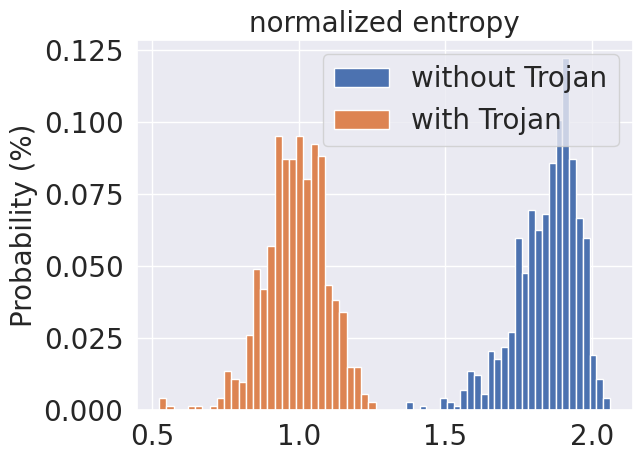

In [25]:
import matplotlib.pyplot as plt
bins = 30
plt.hist(final_entropy_bb, bins, weights=np.ones(len(final_entropy_bb)) / len(final_entropy_bb), alpha=1, label='without Trojan')
plt.hist(final_entropy_tb, bins, weights=np.ones(len(final_entropy_tb)) / len(final_entropy_tb), alpha=1, label='with Trojan')

plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig(output_path) # save the fig as pdf file

In [26]:
import scipy
import scipy.stats
import pandas as pd 

FRR = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8]
data = []

for r in FRR:
  threshold_idx = int(n_test * r) #use a preset FRR of 0.01. This can be 
  threshold = final_entropy_bb[np.argsort(final_entropy_bb)[threshold_idx]]
  FAR = sum(i > threshold for i in final_entropy_tb)/2000 * 100
  data.append([r, FAR, threshold])

# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['FRR', 'FAR', 'Threshold']) 
print(df)

     FRR  FAR  Threshold
0  0.005  0.0   1.493908
1  0.010  0.0   1.514327
2  0.020  0.0   1.576356
3  0.030  0.0   1.595146
4  0.050  0.0   1.636530
5  0.100  0.0   1.701957
6  0.200  0.0   1.761250
7  0.400  0.0   1.841329
8  0.800  0.0   1.933481
